In [1]:
# Runtime
import time as t
start_time = t.time()

### Data loading into dataframe

This section performs the following operations:
1. Imports the neccesary modules for subsequent analyses
1. Imports the data files
1. Cleans and transforms into useable dataframes for each data source.
<br> <br>
See last code block in this section for a list of dataframes created. Use %pip install for modules you have not downloaded if appropriate.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import scipy.fftpack as fft
# import scipy.io.wavfile as wav
# import soundfile as sf
import pandas as pd
import seaborn as sns
from IPython.display import display, clear_output
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow import keras
import random
import math

# Ignore all warnings
warnings.filterwarnings("ignore")

1. ___1___ is Section
1. ___3___ is Class
1. ___4___ is Subclass

**Please replace file destination source here.**

In [3]:
volks_1_src = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\Lv1Volkswagen1980To2010.txt"
volks_3_src = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\Lv3Volkswagen1980To2010.txt"
volks_4_src = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\Lv4Volkswagen1980To2010.txt"

b60_1_src = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\Lv1B601980To2010.txt"
b60_3_src = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\Lv3B601980To2010.txt"
b60_4_src = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\Lv4B601980To2010.txt"

b60l_1_src = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\Lv1B60L1980To2010.txt"
b60l_3_src = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\Lv3B60L1980To2010.txt"
b60l_4_src = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\Lv4B60L1980To2010.txt"

future_src = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\Lv4Volkswagen2011To2015.txt"

In [4]:
def columns_with_zeros(df):
    zero_columns = [col for col in df.columns if (df[col] == 0).all()]
    return zero_columns

def make_df(fp):
    df_data = []
    column_headers = []
    count = 0
    with open(fp, 'r') as file:
        for line in file:
            row = line.strip().split()
            column_headers.append(row[0])  
            df_data.append([int(val) for val in row[1:]])
            count += 1
    df = pd.DataFrame(df_data)
    df = df.T
    df.columns = column_headers
    # Note here I remove all the zero columns for simplicity
    # zero_columns = columns_with_zeros(df)
    # df = df.drop(columns=zero_columns)
    date_range = pd.date_range(start='1980-01-01', end='2010-12-31', freq='Y')
    # Add the date_range as the first column to the existing DataFrame
    df.insert(0, 'Years', date_range)
    return df

def make_df1(fp):
    df_data = []
    column_headers = []
    count = 0
    with open(fp, 'r') as file:
        for line in file:
            row = line.strip().split()
            column_headers.append(row[0])  
            df_data.append([int(val) for val in row[1:]])
            count += 1
    df = pd.DataFrame(df_data)
    df = df.T
    df.columns = column_headers
    # Note here I remove all the zero columns for simplicity
    # zero_columns = columns_with_zeros(df)
    # df = df.drop(columns=zero_columns)
    date_range = pd.date_range(start='2011-01-01', end='2015-12-31', freq='Y')
    # Add the date_range as the first column to the existing DataFrame
    df.insert(0, 'Years', date_range)
    return df

volks_1_df = make_df(volks_1_src)
volks_3_df = make_df(volks_3_src)
volks_4_df = make_df(volks_4_src)
b60_1_df = make_df(b60_1_src)
b60_3_df = make_df(b60_3_src)
b60_4_df = make_df(b60_4_src)
b60l_1_df = make_df(b60l_1_src)
b60l_3_df = make_df(b60l_3_src)
b60l_4_df = make_df(b60l_4_src)
future_df = make_df1(future_src)
total_df = pd.concat([volks_4_df, future_df], axis=0, ignore_index=True)
df_list = [volks_1_df, volks_3_df, volks_4_df, b60_1_df, b60_3_df, b60_4_df, b60l_1_df, b60l_3_df, b60l_4_df, future_src]
date_range = volks_4_df['Years']

In [5]:
# Get the column names as sets
volks_columns = set(volks_4_df.columns)
b60_columns = set(b60_4_df.columns)
b60l_columns = set(b60l_4_df.columns)

# Find symmetric differences
volks_unique = volks_columns - (b60_columns | b60l_columns)
b60_unique = b60_columns - (volks_columns | b60l_columns)
b60l_unique = b60l_columns - (volks_columns | b60_columns)

print("Columns unique to volks_4_df:", volks_unique)
print("Columns unique to b60_4_df:", b60_unique)
print("Columns unique to b60l_4_df:", b60l_unique)

Columns unique to volks_4_df: set()
Columns unique to b60_4_df: set()
Columns unique to b60l_4_df: set()


### **Note**
1. Functions ONLY take in dataframe with 'Years' column INCLUDED unless otherwise mentioned.
1. Removing 'Years' column is part of process inside Tensorflow or Audio test etc. 
1. This does NOT affect EDA. See individual formatting.
1. Tensorflow MAE results may vary due to nature of machine learning.

### Functions

Current functions include:
1. create_3d_spectrogram(df, category_label, time_label, freq_label, title)
1. create_2d_spectrogram(df, category_label, time_label, title, max_xticks=10, max_yticks=5, cmap='viridis')
1. generate_kde_plot(df, x_cols(optional))
1. plot_moving_average(df, window_size, col_name(optional))
1. moving_average_forecast(df, actual_df, num_forecast_values=5, max_n_values=20)
1. ema_forecast_and_plot(full_df, future_df, alpha_values, num_forecast_values=5)

<br>
**Note** : moving_average_forecast and ema_forecast_and_plot uses dataframes without the "Years" column, ensure the right column is dropped prior to calling it. Audio-related functions are in that section's block.

In [6]:
def create_3d_spectrogram(df, category_label, time_label, freq_label, title):
    """
    Plots a 3D Spectrogram

    Remember to look at your dataframe accordingly to adjust to the parameters.

    Inputs:
    df              :   DataFrame WITH "Years" column
    category_label  :   The x-axis label (column headers). E.g. Subclasses/Classes
    time_label      :   The y-axis label ("Years")
    freq_label      :   The frequency label ("Frequency")
    title           :   Plot title

    Output:
    3D Spectrogram of dataframe
    """
    years = pd.to_datetime(df["Years"]).dt.year  # Extract years from the "Years" column
    unique_years = sorted(years.unique())  # Get unique years
    X, Y = np.meshgrid(range(df.shape[1] - 1), unique_years)
    Z = df.iloc[:, 1:].values
    labels = df.columns[1:].tolist()

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel(category_label)
    ax.set_ylabel(time_label)
    ax.set_zlabel(freq_label)
    ax.set_title(title)

    # ax.set_xticks(range(len(labels)))
    # ax.set_xticklabels(labels, rotation=45, ha='right')

    x_tick_positions = list(range(0, len(labels), 80))
    x_tick_labels = [labels[i] for i in x_tick_positions]
    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, rotation=45, ha='right')

    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    plt.show()

In [7]:
def create_2d_spectrogram(df, category_label, time_label, title, max_xticks=10, max_yticks=5, cmap='viridis'):
    '''
    Plots a 2D Spectrogram
    
    Inputs:
    df              :   DataFrame WITH "Years" column
    category_label  :   The x-axis label (column headers)
    time_label      :   The y-axis label ("Years")
    title           :   Plot title

    Output:
    2D Spectrogram of dataframe
    '''
    years = pd.to_datetime(df['Years']).dt.year
    freq = df.iloc[:, 1:].values

    X, Y = np.meshgrid(range(freq.shape[1]), range(freq.shape[0]))

    fig, ax = plt.subplots(figsize=(10, 3))

    im = ax.imshow(freq, cmap=cmap, origin='lower', aspect='auto')

    ax.set_xlabel(category_label)
    ax.set_ylabel(time_label)
    ax.set_title(title)

    # Dynamically determine x-axis tick locations and labels
    x_ticks = np.linspace(0, freq.shape[1] - 1, num=min(max_xticks, freq.shape[1]), dtype=int)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(df.columns[1:][x_ticks], fontsize=6)

    # Dynamically determine y-axis tick locations and labels
    y_ticks = np.linspace(0, freq.shape[0] - 1, num=min(max_yticks, freq.shape[0]), dtype=int)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([years[y] for y in y_ticks], fontsize=6)

    plt.tight_layout()
    plt.show()

In [8]:
def generate_kde_plot(df, x_cols=None):
    '''
    Generates the row_sum KDE for random columns of df that include the Years in the first column, 
    or for specific columns if x_cols is provided.

    Inputs:         
    df              :   DataFrame WITH "Years" column
    x_cols          :   String of single column name or List of column names (optional)

    Output:
    KDE plot for one column, more if explicit.

    Valid Inputs:
    volks_1/3/4_df, b60_1/3/4_df, b60l_1/3/4_df

    Notes:
    If x_cols is None, a random column will be chosen.
    If x_cols is provided, KDE plots will be generated for those columns on the same graph.
    '''
    if x_cols is None:
        # Select a random column from the DataFrame starting from the 2nd column
        random_column = random.choice(df.columns[1:])

        # Calculate row sums starting from the 2nd column
        row_sums = df.iloc[:, 1:].sum(axis=1)

        # Create a new DataFrame with the random column and row sums
        plot_data = pd.DataFrame({
            'x_value': df[random_column],
            'row_sums': row_sums
        })

        # Create a KDE plot
        sns.kdeplot(data=plot_data, x='x_value', y='row_sums', cmap="Blues", fill=True)

        # Set plot labels and title
        plt.xlabel('Frequency')
        plt.ylabel('Year Sums')
        plt.title(f'Year-sum KDE for {random_column}')
    else:
        if isinstance(x_cols, str):
            x_cols = [x_cols]  # Convert single string input to list

        # Validate column names in x_cols
        invalid_columns = [col for col in x_cols if col not in df.columns]
        if invalid_columns:
            raise ValueError(f"The following columns are invalid: {', '.join(invalid_columns)}")

        # Calculate row sums starting from the 2nd column
        row_sums = df.iloc[:, 1:].sum(axis=1)

        # Create a KDE plot for each specified column
        for idx, x_col in enumerate(x_cols):
            plot_data = pd.DataFrame({
                'x_value': df[x_col],
                'row_sums': row_sums
            })
            color = sns.color_palette("tab10")[idx]  # Choose a color from the palette
            sns.kdeplot(data=plot_data, x='x_value', y='row_sums', cmap="Blues", fill=True, label=x_col, color=color)
        # Set plot labels and title
        plt.xlabel('Frequency')
        plt.ylabel('Year Sums')
        title = ','.join(x_cols)
        plt.title(f'Year-sum KDE for {title}')
        plt.legend()

    # Display the plot
    plt.show()

In [9]:
def plot_moving_average(df, window_size, col_name=None, plot_original=True):
    """
    Calculate and plot the center moving average of a single column in a DataFrame.

    Inputs:
    df                              :   DataFrame WITH "Years" column
    col_name (str or list of str)   :   The name of the column to calculate the moving average for.
    window_size (int or list or int):   The size of the moving average window.
    plot_original (bool)            :   Whether to plot the original data along with the moving average.

    Output:
    Plot of moving averages for a column
    """

    if col_name is None:
        col_name = np.random.choice(df.columns[1:])  # Randomly select a column

    plt.figure(figsize=(10, 6))
    plt.title(f'Centered Moving Averages of {col_name}')

    if isinstance(window_size, int):
        window_sizes = [window_size]  # Convert integer to a list
    elif isinstance(window_size, list):
        window_sizes = window_size
    else:
        raise ValueError("window_size should be an integer or a list of integers.")


    for window in window_sizes:
        moving_avg = df[col_name].rolling(window=window, center=True).mean()
        label = f'Moving Average ({window} periods)'
        plt.plot(df.index, moving_avg, label=label)

    if plot_original:
        plt.plot(df.index, df[col_name], label=f'Original {col_name}', alpha=0.5)

    custom_x_ticks = range(1980, 2011, 5)
    plt.xticks([0,5,10,15,20,25,30], range(1980,2011,5))
    plt.xlabel("Years")
    plt.ylabel(col_name)
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
def moving_average_forecast(df, actual_df, num_forecast_values=5, max_n_values=20):
    '''   
    Inputs: 
    df                          :   Dataframe of original values WITHOUT "Years" column
    actual_df                   :   Dataframe of actual future values WITHOUT "Years" column
    num_forecast_values (int)   :   Number of future forecasts to make.
    max_n_values (int)          :   Number of averages to check.

    How to adjust inputs:
    Ensure you drop the Years column as follows:
    v4_timeless = volks_4_df.drop(columns='Years')
    future_timeless = future_df.drop(columns='Years')
    
    Then:
    moving_average_forecast(v4_timeless, future_timeless)

    Output:
    Forecast MAE vs max n plot. Best Forecast MAE
    Random plot of 3 forecasted columns for the entire duration.
    '''
    forecast_mae_values = []
    forecast_dfs = []
    
    for n in range(1, max_n_values + 1):
        if n == 1:
            forecast_df = df.copy()
            forecast_values = [df.iloc[-1]] * num_forecast_values
            forecast_df = pd.concat([forecast_df, pd.DataFrame(forecast_values)], ignore_index=True)
            forecast_dfs.append(forecast_df)
        else:
            forecast_df = df.copy()
            for i in range(num_forecast_values):
                last_n_rows = forecast_df.tail(n).sum()/n
                forecast_df = forecast_df.append(last_n_rows, ignore_index=True)
                if i == num_forecast_values-1:
                    forecast_dfs.append(forecast_df)
        
    for n, forecast_df in enumerate(forecast_dfs, start=1):
        # forecast_df = forecast_df.applymap(lambda x: math.floor(x) if x < 0.5 else math.ceil(x))
        last_5_only = forecast_df.iloc[-5:].copy().reset_index(drop=True)
        forecast_mae = np.mean(np.abs(actual_df - last_5_only)).mean()
        forecast_mae_values.append(forecast_mae)

    # Print best forecast MAE
    best_n_index = forecast_mae_values.index(min(forecast_mae_values))
    best_MAE_value = forecast_mae_values[best_n_index]
    best_n_value = best_n_index + 1
    print("The minimum forecast MAE is {} for n={}".format(best_MAE_value, best_n_value))

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_n_values + 1), forecast_mae_values, marker='o')
    plt.title('Forecast MAE vs. n')
    plt.xlabel('n')
    plt.ylabel('Forecast MAE')
    plt.xticks(range(2, 21, 2))
    plt.grid(True)
    plt.show()

    # Select 3 random columns with non-zero last values in df
    non_zero_columns = df.columns[(df.iloc[-1] != 0)].tolist()
    selected_columns = np.random.choice(non_zero_columns, 3, replace=False)

    best_forecast_df = forecast_dfs[best_n_index]
    merged_df = pd.concat([df, actual_df], axis=0).reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r']  # Example colors, you can change them
    line_styles = ['-', '-', '--']  # Solid lines for original and actual, dashed for forecast

    for idx, col in enumerate(selected_columns):
        plt.plot(range(30, 36), best_forecast_df[col].values[-6:], label=f'Forecast {col}', color=colors[idx], linestyle=line_styles[2])
        plt.plot(range(len(merged_df)), merged_df[col], label=f'Actual {col}', color=colors[idx], linestyle=line_styles[0])
    plt.axvline(x=30, color='gray', linestyle='--', linewidth=0.5)
    plt.title('Forecast vs. Actual vs. Original for Best MAE')
    plt.xlabel('Time')
    plt.ylabel('Values')
    custom_x_ticks = [0, 5, 10, 15, 20, 25, 30, 35]
    custom_x_labels = list(range(1980, 2016, 5))
    plt.xticks(custom_x_ticks, custom_x_labels, rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

In [11]:
def ema_forecast_and_plot(full_df, future_df, alpha_values, num_forecast_values=5):
    """
    Calculate EMA forecasts for different alpha values and plots one of the alpha forecasts.

    Inputs: 
    full_df                     :   Dataframe of ALL values WITHOUT "Years" column
    actual_df                   :   Dataframe of actual future values WITHOUT "Years" column
    alpha_values                :   Range of values of alpha between 0 and 1
    num_forecast_values         :   Number of forecasts to make (5)

    How to adjust inputs:
    Ensure you drop the Years column as follows:
    total_timeless = total_df.drop(columns='Years')
    future_timeless = future_df.drop(columns='Years')
    
    Then:
    best_alpha, best_mae = ema_forecast_and_plot(total_timeless, future_timeless, alpha_values)

    Output:
    Forecast MAE vs alpha plot. Best Forecast MAE
    Random plot of 3 forecasted columns for the entire duration.
    """
    def calculate_ema_forecast(data, alpha, num_forecast_values=num_forecast_values):
        formula_value = data[0]
        ema_forecast = [formula_value]
        for i in range(1, len(data)):
            current_value = data[i]
            formula_value = alpha * current_value + (1 - alpha) * formula_value
            ema_forecast.append(formula_value)
        return ema_forecast

    best_alpha = None
    best_mae = float('inf')
    mae_values = []
    df_to_plot = pd.DataFrame()

    for alpha in alpha_values:
        forecast_df = pd.DataFrame()
        for column in full_df.columns:
            forecast = calculate_ema_forecast(full_df[column].values, alpha)
            forecast_df[column] = forecast
        mae = np.mean(np.abs(future_df.values - forecast_df.iloc[-5,:].values)).mean()
        mae_values.append(mae)

        if mae < best_mae:
            best_alpha = alpha
            best_mae = mae

    for column in full_df.columns:
        plot_forecast = calculate_ema_forecast(full_df[column].values, best_alpha)
        df_to_plot[column] = plot_forecast

    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values, mae_values, marker='o', linestyle='-', color='b')
    plt.xlabel('Alpha (Smoothing Factor)')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Alpha vs. MAE')
    plt.grid(True)
    plt.show()
    
    # If 2011-2015 is 0, no point plotting.
    non_zero_columns = [col for col in future_df.columns if any(future_df[col] != 0)]
    if len(non_zero_columns) >= 3:
        selected_columns = np.random.choice(non_zero_columns, 3, replace=False)
    else:
        selected_columns = non_zero_columns

    # print("Columns in selected_columns:", selected_columns)
    # print("Columns in df_to_plot:", df_to_plot.columns)
    
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r']  # Example colors, you can change them
    line_styles = ['-', '-', '--']  # Solid lines for original and actual, dashed for forecast

    for idx, col in enumerate(selected_columns):
        plt.plot(range(31, 36), df_to_plot[col].values[-5:], label=f'Forecast {col}', color=colors[idx], linestyle=line_styles[2])
        plt.plot(range(len(full_df)), full_df[col], label=f'Actual {col}', color=colors[idx], linestyle=line_styles[0])
    plt.axvline(x=30, color='gray', linestyle='--', linewidth=0.5)
    plt.title('Forecast vs. Actual for best alpha = {:.3f}'.format(best_alpha))
    plt.xlabel('Time')
    plt.ylabel('Values')
    custom_x_ticks = [0, 5, 10, 15, 20, 25, 30, 35]
    custom_x_labels = list(range(1980, 2016, 5))
    plt.xticks(custom_x_ticks, custom_x_labels, rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

    return best_alpha, best_mae

Debug functions here if neccesary.

### Exploratory Data Analysis

The top 10 "highest performing" groups. 

In [12]:
column_sums = volks_4_df.iloc[:, 1:].sum()
top_10_tuples = [(column, value) for column, value in column_sums.nlargest(15).items()]
print("Top 15 Subclasses:")
for column, value in top_10_tuples[:15]:
    print(column,",",value)

column_sums1 = total_df.iloc[:, 1:].sum()
top_10_tuples1 = [(column, value) for column, value in column_sums1.nlargest(15).items()]
print("Top 10 Subclasses:")
for column, value in top_10_tuples1[:15]:
    print(column,",",value)

Top 15 Subclasses:
F02D , 1301
B60R , 1284
F16H , 956
F02B , 859
B60K , 803
F01N , 772
G06F , 767
B60W , 738
F02M , 635
B60T , 527
B62D , 478
F02F , 334
G01C , 318
F16D , 316
F01L , 308
Top 10 Subclasses:
B60R , 1564
F02D , 1415
G06F , 1252
F16H , 1066
B60K , 1045
B60W , 1013
F02B , 903
F01N , 887
F02M , 674
B62D , 580
B60T , 573
G01C , 459
H01M , 416
G08G , 384
G01S , 360


Mutual Information (MI) and Absolute Correlation (AC) of Groups on Row/Year-sums
1. Higher MI indiciates Subclass contains information useful to predict row-sums
1. Higher AC indicates Subclass is more correlated with to the year-sums. (BOTH -ve and +ve)

For Volkswagen 1980-2015

In [13]:
from sklearn.feature_selection import mutual_info_regression

row_sums = total_df.iloc[:,1:].sum(axis=1)
correlation_results = total_df.iloc[:,1:].apply(lambda col: col.corr(row_sums))
mi_results = mutual_info_regression(total_df.iloc[:,1:], row_sums)
result_df = pd.DataFrame({
    'Correlation': correlation_results,
    'Mutual_Information': mi_results
})
result_df['Abs_Correlation'] = result_df['Correlation'].abs()
result_df = result_df.sort_values(by=['Abs_Correlation', 'Mutual_Information'], ascending=False)
print(result_df)

      Correlation  Mutual_Information  Abs_Correlation
G05B     0.756152            0.405618         0.756152
H04M     0.739381            0.353562         0.739381
G07C     0.701565            0.167007         0.701565
B60K     0.692041            0.268770         0.692041
H04B     0.691229            0.244009         0.691229
...           ...                 ...              ...
H03C          NaN            0.000000              NaN
H03D          NaN            0.000000              NaN
H05C          NaN            0.000000              NaN
H05F          NaN            0.000000              NaN
H05G          NaN            0.000000              NaN

[645 rows x 3 columns]


For B60 1980-2010

In [14]:
row_sums1 = b60_4_df.iloc[:,1:].sum(axis=1)
correlation_results1 = b60_4_df.iloc[:,1:].apply(lambda col: col.corr(row_sums1))
mi_results1 = mutual_info_regression(b60_4_df.iloc[:,1:], row_sums1)
result_df1 = pd.DataFrame({
    'Correlation': correlation_results1,
    'Mutual_Information': mi_results1
})
result_df1['Abs_Correlation'] = result_df1['Correlation'].abs()
result_df1 = result_df1.sort_values(by=['Abs_Correlation', 'Mutual_Information'], ascending=False)
print(result_df1)

      Correlation  Mutual_Information  Abs_Correlation
A47C     0.888587            0.416328         0.888587
F02B     0.880025            0.578710         0.880025
F01P     0.875320            0.617441         0.875320
E05C     0.871645            0.468976         0.871645
B62D     0.866366            0.449108         0.866366
...           ...                 ...              ...
H05C          NaN            0.000000              NaN
H05F          NaN            0.000000              NaN
H05G          NaN            0.000000              NaN
H05H          NaN            0.000000              NaN
H99Z          NaN            0.000000              NaN

[645 rows x 3 columns]


Total Frequency across years, and Frequency Histogram

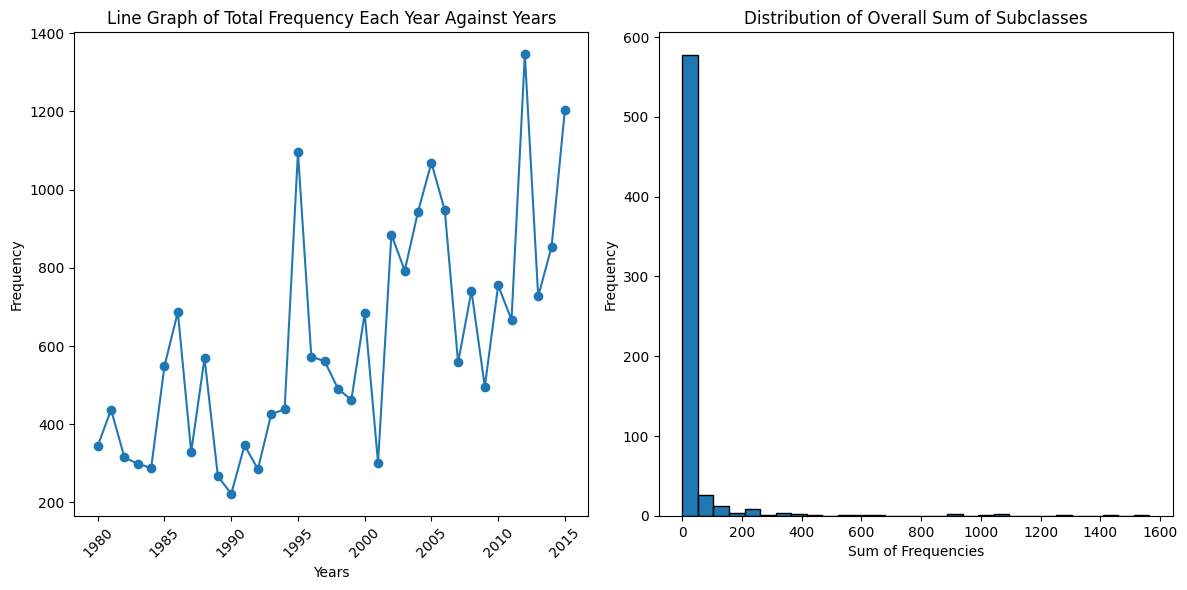

In [15]:
row_sums = total_df.iloc[:, 1:].sum(axis=1)
years = pd.to_datetime(total_df.iloc[:, 0]).dt.year

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(years, row_sums, marker='o')
ax1.set_title("Line Graph of Total Frequency Each Year Against Years")
ax1.set_xlabel("Years")
ax1.set_ylabel("Frequency")
# ax1.legend()
ax1.tick_params(axis='x', rotation=45)

column_sums = total_df.iloc[:, 1:].sum()
ax2.hist(column_sums, bins=30, edgecolor='black')
ax2.set_title("Distribution of Overall Sum of Subclasses")
ax2.set_xlabel("Sum of Frequencies")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Moving averages plot

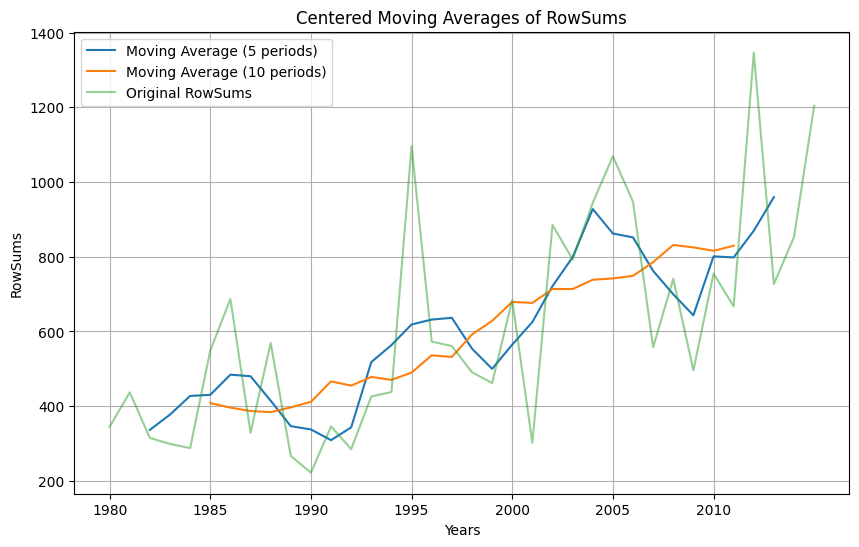

In [16]:
row_sum_df = pd.DataFrame()
row_sum_df['Years'] = total_df['Years']
# row_sum_df.set_index('Years', inplace=True)
row_sum_df['RowSums'] = total_df.iloc[:, 1:].sum(axis=1)
plot_moving_average(row_sum_df,[5,10], 'RowSums')

Seasonal Decomposition (Run block above first)

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(
    row_sum_df['RowSums'],
    model = 'additive',
    period = 10
)

trend = result.trend
seasonal = result.seasonal
residual = result.resid

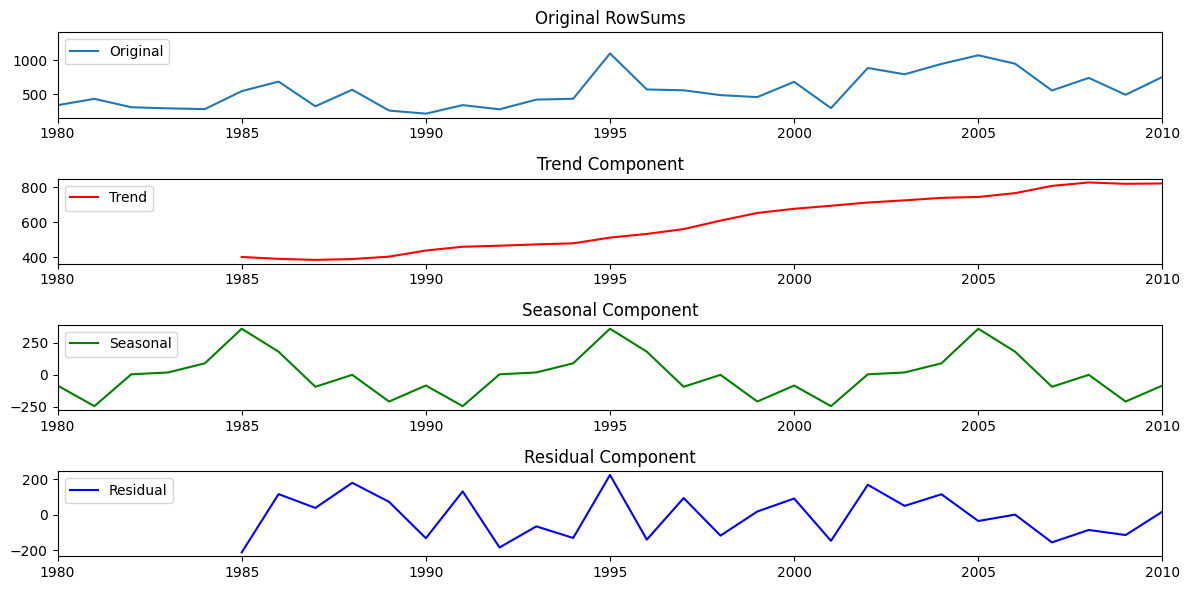

In [18]:
# Plot the original time series
plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(row_sum_df.index, row_sum_df['RowSums'], label='Original')
custom_x_ticks = range(1980, 2011, 5)
plt.xticks([0,5,10,15,20,25,30], range(1980,2011,5))
plt.xlim([0,30])
plt.legend(loc='upper left')
plt.title('Original RowSums')

# Plot the trend component
plt.subplot(412)
plt.plot(trend.index, trend, label='Trend', color='red')
custom_x_ticks = range(1980, 2011, 5)
plt.xticks([0,5,10,15,20,25,30], range(1980,2011,5))
plt.xlim([0,30])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal.index, seasonal, label='Seasonal', color='green')
custom_x_ticks = range(1980, 2011, 5)
plt.xticks([0,5,10,15,20,25,30], range(1980,2011,5))
plt.xlim([0,30])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual.index, residual, label='Residual', color='blue')
custom_x_ticks = range(1980, 2011, 5)
plt.xticks([0,5,10,15,20,25,30], range(1980,2011,5))
plt.xlim([0,30])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

Lagged Scatterplot for row sums

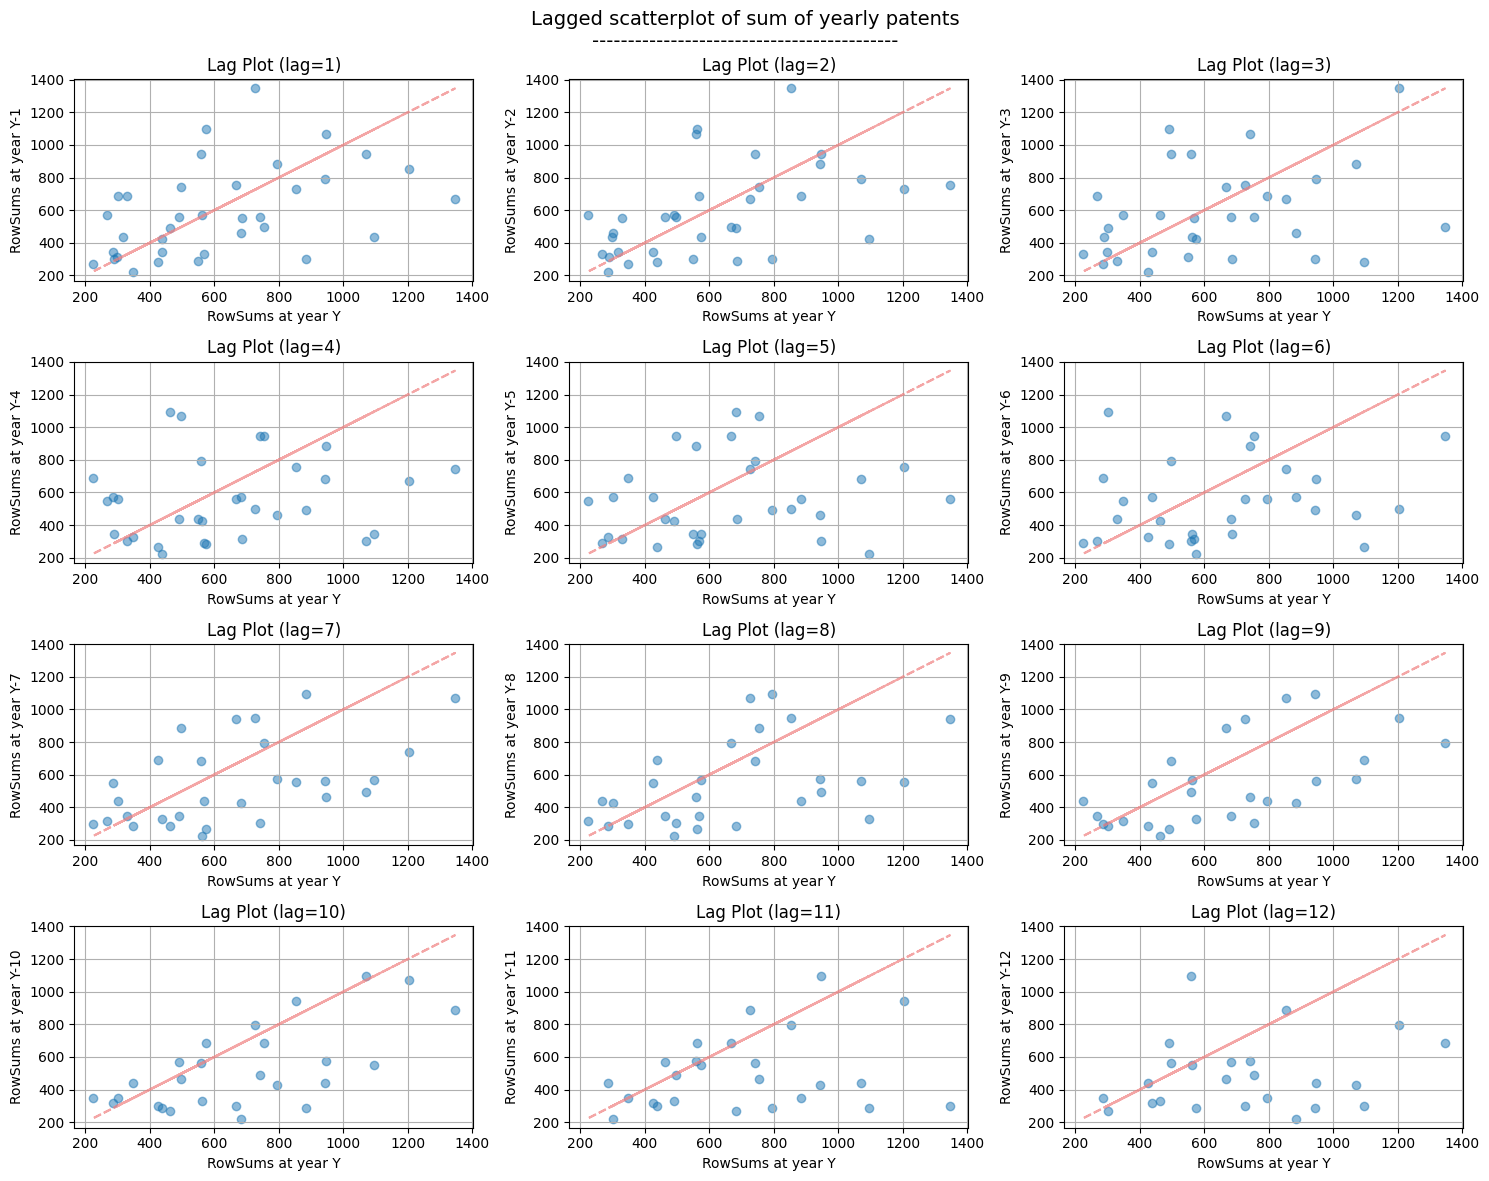

In [19]:
lag_max = 12
nrows, ncols = 4, 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))

row_sum_df = pd.DataFrame()
row_sum_df['Years'] = total_df['Years']
# row_sum_df.set_index('Years', inplace=True)
row_sum_df['RowSums'] = total_df.iloc[:, 1:].sum(axis=1)

for lag in range(1, lag_max + 1):
    ax = axes[(lag - 1) // ncols, (lag - 1) % ncols]
    row_sum_df['Lagged'] = row_sum_df['RowSums'].shift(lag)
    
    ax.scatter(row_sum_df['RowSums'], row_sum_df['Lagged'], alpha=0.5)
    ax.plot(row_sum_df['RowSums'], row_sum_df['RowSums'], color='lightcoral', linestyle='--', alpha=0.7)
    ax.set_xlabel('RowSums at year Y')
    ax.set_ylabel(f'RowSums at year Y-{lag}')
    ax.set_title(f'Lag Plot (lag={lag})')
    ax.grid(True)

for i in range(lag_max + 1, nrows * ncols + 1):
    fig.delaxes(axes.flatten()[i - 1])

suptitle = fig.suptitle("Lagged scatterplot of sum of yearly patents", fontsize=14)
suptitle.set_text(suptitle.get_text() + '\n' + '-' * len(suptitle.get_text()))

plt.tight_layout()
plt.show()

Highest patents through the years analysis

In [20]:
column_counts = {}

# Iterate through rows
for index, row in total_df.iloc[:, 1:].iterrows():  
    max_col_name = row.idxmax(skipna=True) 
    if max_col_name in column_counts:
        column_counts[max_col_name] += 1
    else:
        column_counts[max_col_name] = 1

for col_name, count in column_counts.items():
    print(f"Column '{col_name}' appears {count} times as the column with the highest value.")

Column 'F16H' appears 4 times as the column with the highest value.
Column 'F02F' appears 2 times as the column with the highest value.
Column 'B60T' appears 3 times as the column with the highest value.
Column 'F02D' appears 4 times as the column with the highest value.
Column 'F02B' appears 1 times as the column with the highest value.
Column 'F16C' appears 1 times as the column with the highest value.
Column 'F02P' appears 1 times as the column with the highest value.
Column 'B60R' appears 5 times as the column with the highest value.
Column 'F02M' appears 1 times as the column with the highest value.
Column 'F01N' appears 2 times as the column with the highest value.
Column 'B03B' appears 1 times as the column with the highest value.
Column 'B60W' appears 2 times as the column with the highest value.
Column 'G06F' appears 9 times as the column with the highest value.


The following plots the highest patents through the years like a Gantt chart. <br> Adjust name of dataframe and indexing where neccesary.

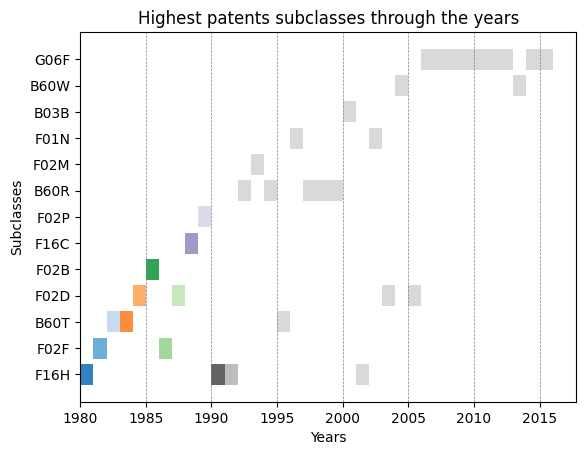

In [21]:
task_names = []
start_times = []
durations = []

years = pd.to_datetime(total_df.iloc[:, 0]).dt.year

for index, row in total_df.iloc[:, 1:].iterrows():
    max_col_name = row.idxmax()  # Find the column name with the maximum value
    task_names.append(max_col_name)
    start_times.append(index)
    durations.append(1)  # Set a duration of 1 for each task

# Create a Gantt chart
fig, ax = plt.subplots()
sorted_task_names = sorted(set(task_names))
unique_colors = plt.cm.get_cmap('tab20c', len(set(task_names)))  # Get a unique color for each task

for i, task in enumerate(task_names):
    color = unique_colors(i)
    ax.barh(task, width=durations[i], left=start_times[i], color=color)

# Add vertical lines at every 5-year interval
for time in range(min(start_times), max(start_times) + 1, 5):
    ax.axvline(time, color='gray', linestyle='--', linewidth=0.5)

# Set labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Subclasses')
ax.set_title('Highest patents subclasses through the years')

# Set x-axis ticks to match the time steps
x_ticks = list(range(1980, 2016, 5))
x_tick_pos = [0,5,10,15,20,25,30,35]
x_labels = [str(year) for year in x_ticks]
ax.set_xticks(x_tick_pos)
ax.set_xticklabels(x_labels)

# Show the plot
plt.show()

Yearly Section Level plot (1980-2010)

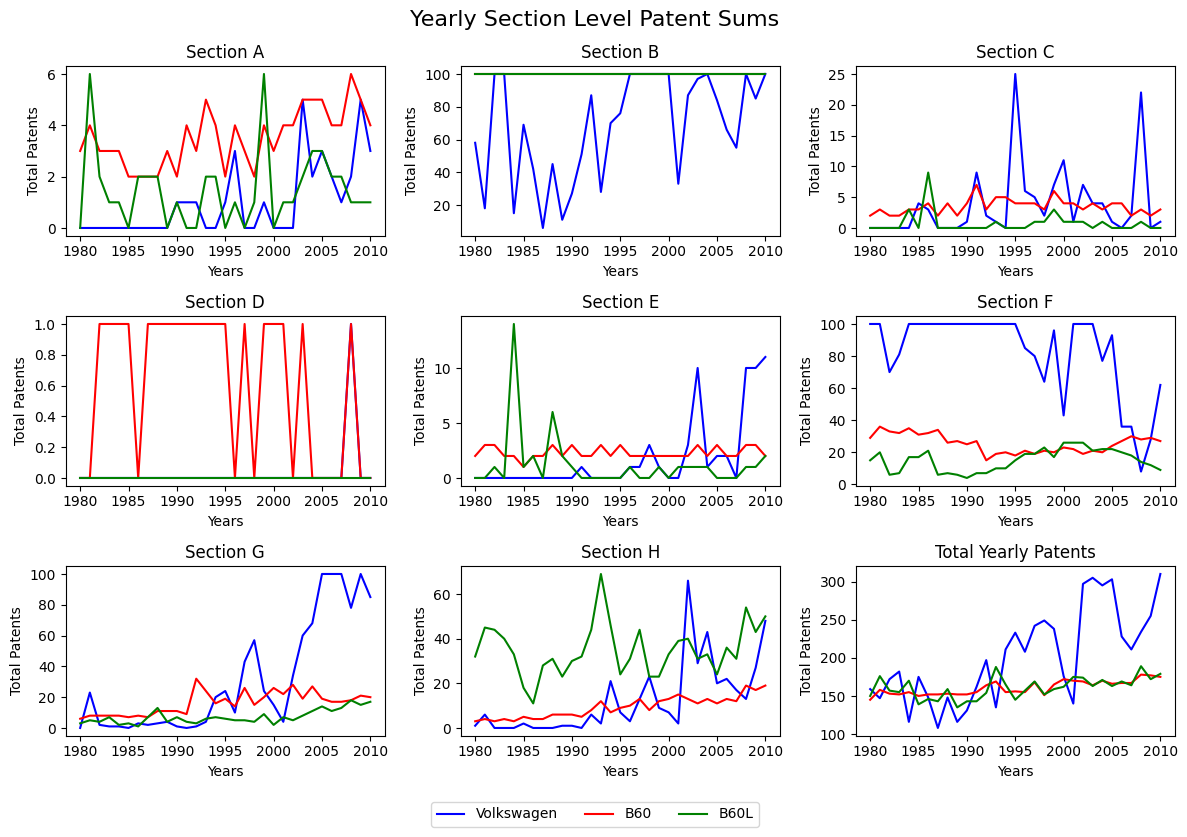

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
colors = ['blue', 'red', 'green']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
fig.suptitle('Yearly Section Level Patent Sums', fontsize=16)
years = pd.to_datetime(volks_1_df.iloc[:, 0]).dt.year

lines = []
labels = ['Volkswagen', 'B60', 'B60L']
dfs = [volks_1_df, b60_1_df, b60l_1_df]

for i, letter in enumerate(letters):
    row = (i) // 3
    col = (i) % 3
    ax = axes[row, col]

    for j, df in enumerate(dfs):
        df_filtered = df[letter]
        line, = ax.plot(years, df_filtered, color=colors[j])
        lines.append(line)
        labels.append(letter)

    ax.set_xlabel('Years')
    ax.set_ylabel('Total Patents')
    ax.set_title(f'Section {letter}')

ax9 = axes[2, 2]
total_patents = [df.iloc[:, 1:].sum(axis=1) for df in dfs]
for j, s in enumerate(total_patents):
    line, = ax9.plot(years, s, color=colors[j], label=labels[j])
    lines.append(line)

ax9.set_xlabel('Years')
ax9.set_ylabel('Total Patents')
ax9.set_title('Total Yearly Patents')

fig.legend(lines, labels[:3], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.show()


Plot for specific subclasses

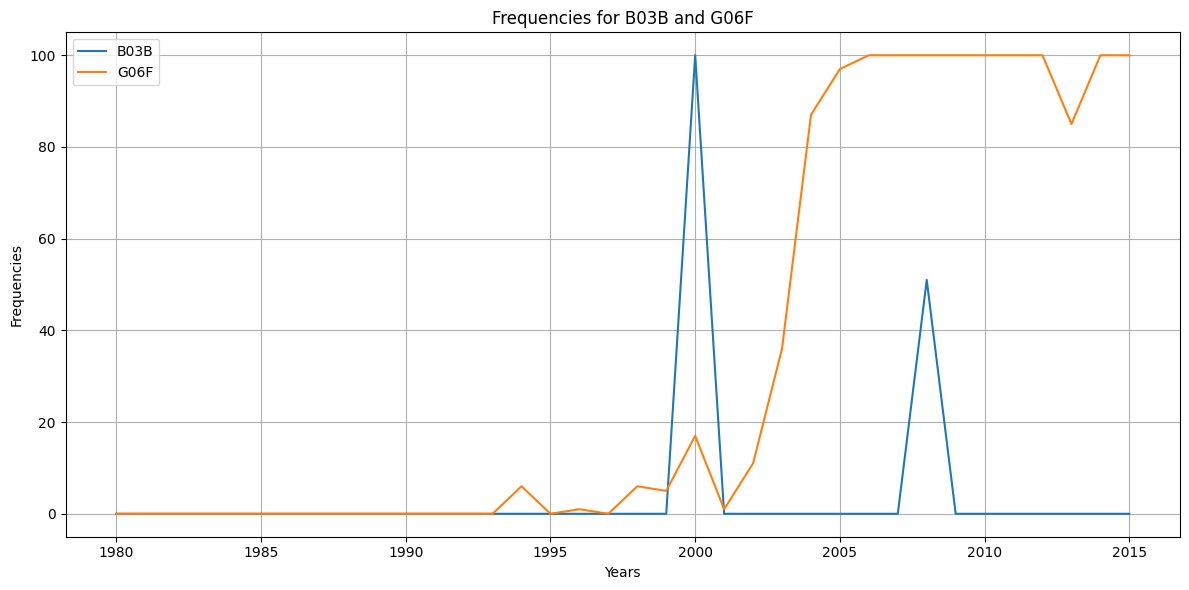

In [23]:
total_df['Years'] = pd.to_datetime(total_df.iloc[:, 0]).dt.year

# Extract data for the columns 'B03B' and 'G06F'
years = total_df['Years']
column_B03B = total_df['B03B']
column_G06F = total_df['G06F']

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(years, column_B03B, label='B03B')
plt.plot(years, column_G06F, label='G06F')

# Set plot labels and title
plt.xlabel('Years')
plt.ylabel('Frequencies')
plt.title('Frequencies for B03B and G06F')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

2D Spectrograms

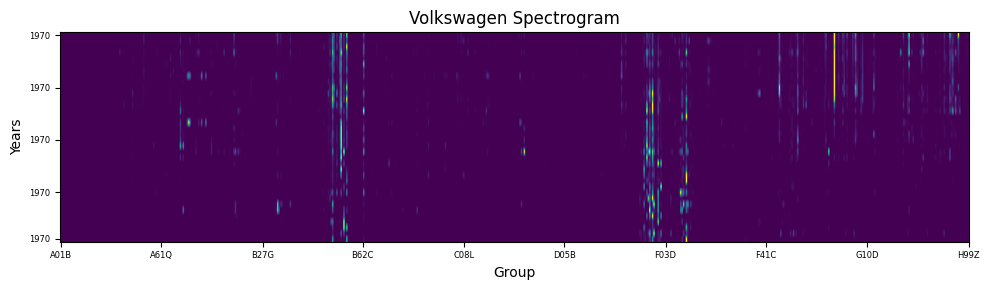

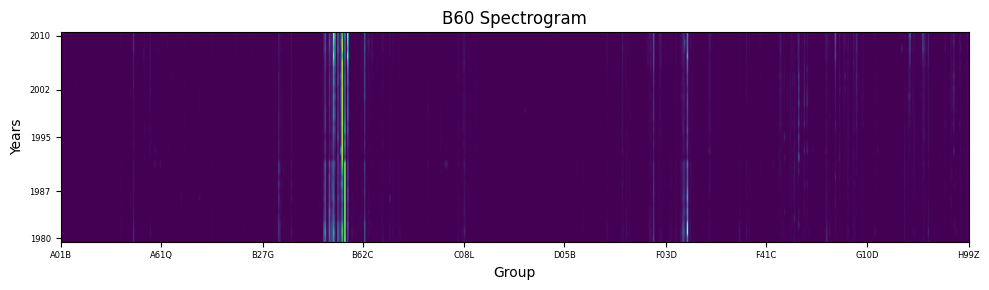

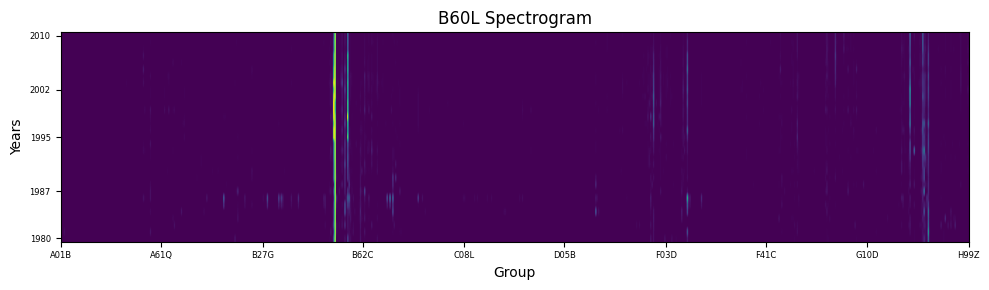

In [24]:
create_2d_spectrogram(total_df, 'Group', 'Years', 'Volkswagen Spectrogram')
create_2d_spectrogram(b60_4_df, 'Group', 'Years', 'B60 Spectrogram')
create_2d_spectrogram(b60l_4_df, 'Group', 'Years', 'B60L Spectrogram')

3D Spectrograms

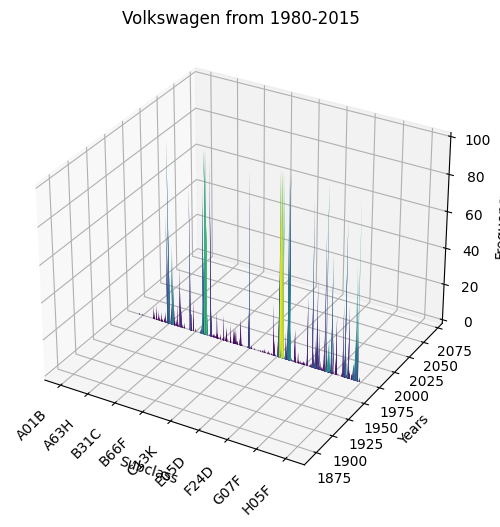

In [25]:
create_3d_spectrogram(total_df, "Subclass","Years", "Frequency", 'Volkswagen from 1980-2015')

KDE of row_sums against individual groups

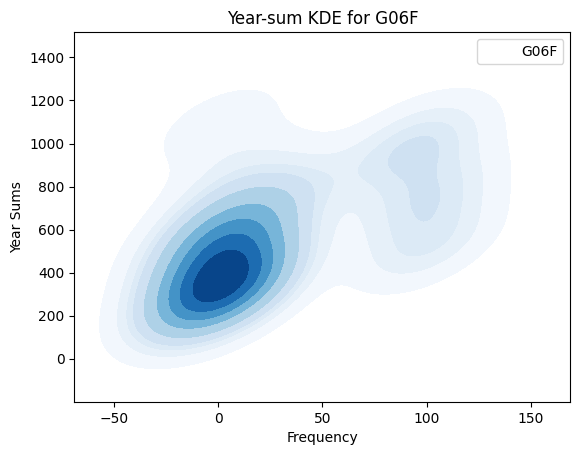

In [26]:
generate_kde_plot(volks_4_df,"G06F")

### Statistical Models

#### Depreciated VAR
1. Trend Assumptions violated and hence not used. Nonetheless original code is as follows.

In [27]:
import random
from statsmodels.tsa.api import VAR

def VAR_df(df, df1, lag_order, columns_to_plot=None):
    '''   
    Plots the VAR forecast for an original dataframe, df, and a true target datframe, df1

    Inputs:
    df  : Dataframe WITHOUT "Years" column
    df1 : True test dataframe WITHOUT "Years" column
    lag_order : Number of shift lags. Typically set to periodicity value
    columns_to_plot : (Optional) Selects 3 random columns to plot if not given

    Outputs:
    Forecast MAE
    VAR predicted vs actual plot
    '''
    model = VAR(df)
    
    # Fit a VAR model on the training data
    results = model.fit(lag_order)

    # Forecast future values for all columns
    n_forecast = df1.shape[0]
    forecast = results.forecast(df.values[-lag_order:], steps=n_forecast)

    # Create a DataFrame with the forecasted values and proper indexing
    forecast_df = pd.DataFrame(index=df1.index, columns=df.columns, data=forecast)

    # Calculate Forecast MAE
    forecast_mae = np.abs(df1 - forecast_df).mean().mean()
    print(forecast_mae)
    
    # If columns_to_plot is not provided, select 3 random columns from df
    if columns_to_plot is None:
        columns_to_plot = random.sample(df.columns.tolist(), 3)

    # Combine df and forecast_df for plotting
    combined_df = pd.concat([df, df1])

    # Reset the index of combined_df to create a continuous index
    combined_df.reset_index(drop=True, inplace=True)
    forecast_df.index = combined_df.index[-5:]

    colors = ['blue', 'orange', 'green', 'red', 'purple']
    
    plt.figure(figsize=(10, 6))
    for i, column in enumerate(columns_to_plot):
        plt.plot(combined_df.index, combined_df[column], marker='o', label=f'Actual {column}', color=colors[i])
        plt.plot(forecast_df.index, forecast_df[column], linestyle='dashed', label=f'Forecast {column}',marker='o', color=colors[i])

    plt.axvline(x=len(df), color='gray', linestyle='--', label='Forecast Start')
    plt.legend()
    plt.xlabel('Years')
    plt.ylabel('Frequencies')
    plt.title(f'VAR Model Forecast (Lag Order: {lag_order})')
    custom_x_ticks = [0, 5, 10, 15, 20, 25, 30, 35]
    custom_x_labels = list(range(1980, 2016, 5))
    plt.xticks(custom_x_ticks, custom_x_labels, rotation=45)
    plt.tight_layout()
    plt.show()

1.0188591559643214


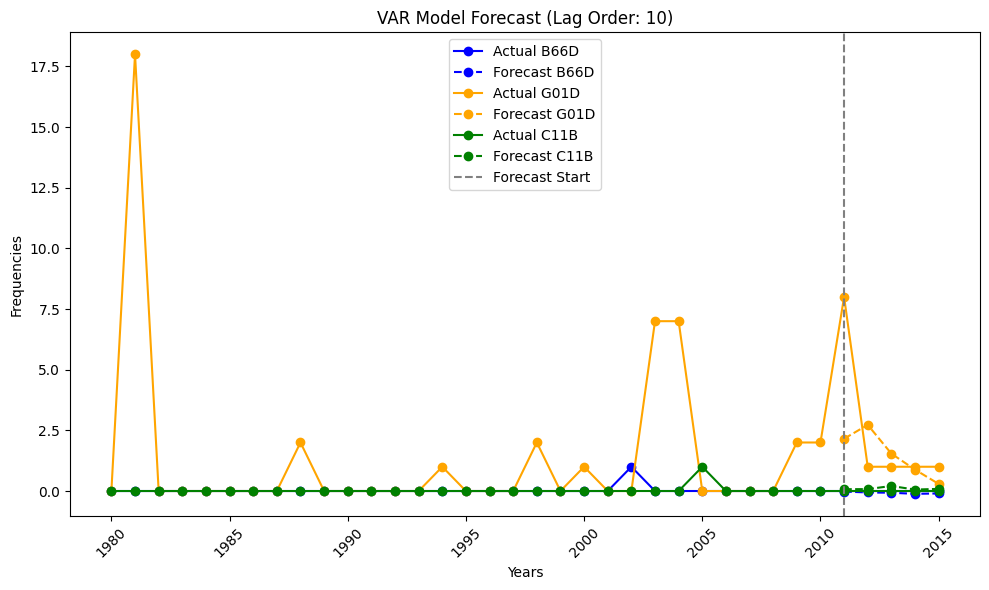

In [28]:
v4_timeless = volks_4_df.drop(columns='Years')
future_timeless = future_df.drop(columns='Years')
# def VAR1_df(df, df1, lag_order, max_tscv_splits)
VAR_df(v4_timeless, future_timeless, 10)

#### Simple Moving Averages

The minimum forecast MAE is 0.9490213178294575 for n=2


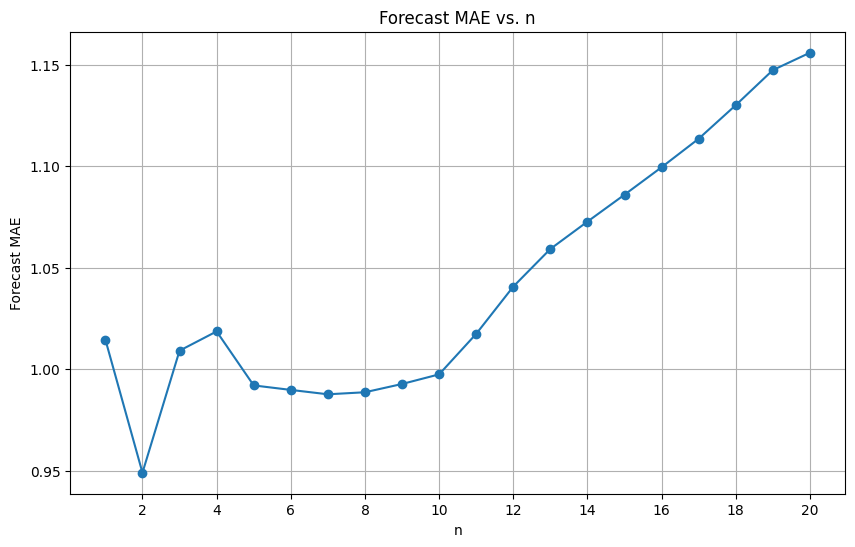

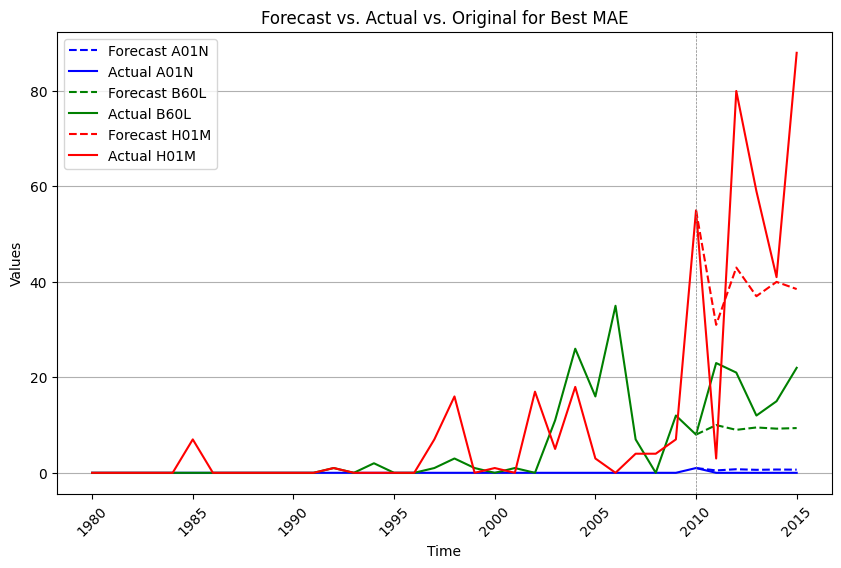

In [29]:
v4_timeless = volks_4_df.drop(columns='Years')
future_timeless = future_df.drop(columns='Years')
moving_average_forecast(v4_timeless, future_timeless)

#### Exponential Moving Averages

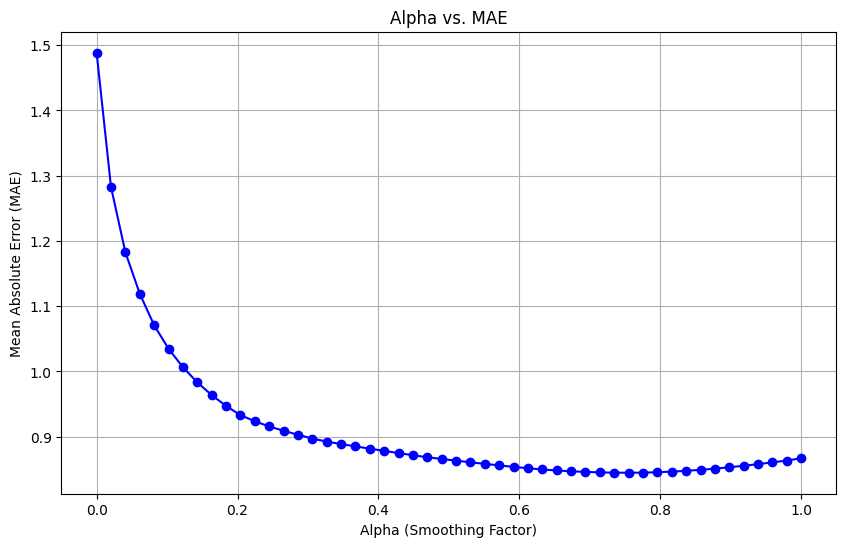

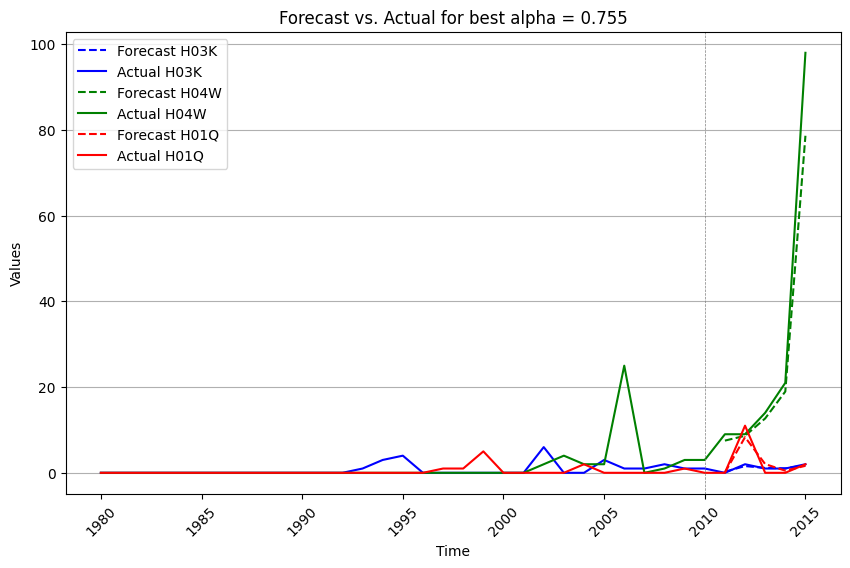

Best Alpha: 0.7551020408163265
Best MAE: 0.8448040445357144


In [30]:
alpha_values = np.linspace(0,1,50)
total_timeless = total_df.drop(columns='Years')
future_timeless = future_df.drop(columns='Years')
best_alpha, best_mae = ema_forecast_and_plot(total_timeless, future_timeless, alpha_values)
print(f"Best Alpha: {best_alpha}")
print(f"Best MAE: {best_mae}")

### Tensorflow ML Models

#### EDAs and data preprocessing

In [31]:
# v4_timeless = volks_4_df.drop(columns='Years')
# future_timeless = future_df.drop(columns='Years')
tf_df = pd.concat([volks_4_df, future_df], axis=0, ignore_index=True)

In [32]:
date_time = pd.to_datetime(tf_df.pop('Years'))

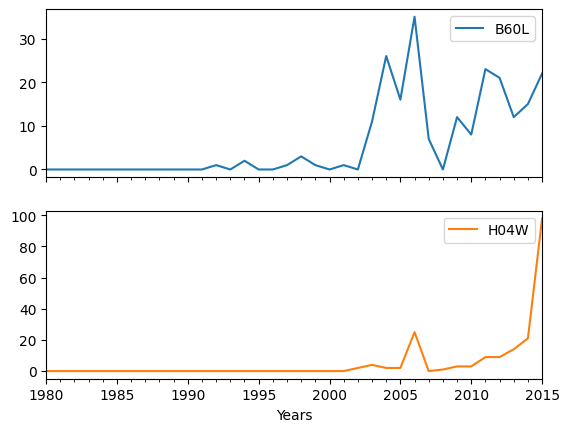

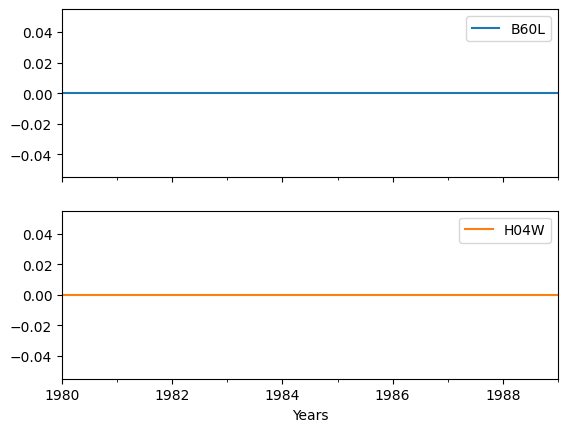

In [33]:
pc = ['B60L', 'H04W']
plot_features = total_df[pc]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = volks_4_df[pc][:10]
plot_features.index = date_time[:10]
_ = plot_features.plot(subplots=True)

In [34]:
tf_df[np.random.choice(tf_df.columns.to_list()[1:], 5, replace=False)].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
B42C,36.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
G03F,36.0,0.166667,0.845154,0.0,0.0,0.0,0.0,5.0
G01L,36.0,0.638889,1.198875,0.0,0.0,0.0,1.0,5.0
H02B,36.0,0.027778,0.166667,0.0,0.0,0.0,0.0,1.0
G09C,36.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Split the data

In [35]:
# Split train/val to 50/50 after getting test_df as the last row
tdf = tf_df.iloc[:,1:].copy()

# Extract the last 10 rows as the test data
test_temp_df = tdf.iloc[-10:]

# Remove the last 10 rows from the DataFrame
tdf = tdf.iloc[:-10]

# Calculate the number of rows for train and validation
n = len(tdf)
n_train = int(n * 0.5)
n_val = n - n_train

# Split the remaining data into train_df and val_df
train_temp_df = tdf[:n_train]
val_temp_df = tdf[n_train:]

Normalize the data

In [36]:
train_temp_mean = train_temp_df.mean()
# Find the column names with zero mean in train_df
zero_mean_columns = train_temp_df.columns[train_temp_mean == 0]

# Drop these columns from all three dataframes
train_df = train_temp_df.drop(columns=zero_mean_columns)
val_df = val_temp_df.drop(columns=zero_mean_columns)
test_df = test_temp_df.drop(columns=zero_mean_columns)

train_mean = train_df.mean()
train_std = train_df.std()

train_std[train_std == 0] = 1e-8

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

**Change training columns list file save-destination location here**

In [37]:
file_path = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\training_columns.txt"

# Open the file in write mode and write each column name on a separate line
with open(file_path, 'w') as file:
    for column_name in train_df.columns:
        file.write(column_name + '\n')

print("Output has been saved to:", file_path)

Output has been saved to: C:\Users\james\OneDrive\Desktop\Thesis\Data\training_columns.txt


Making sure no empty columns in training

In [38]:
print("Train, val, test with zero columns: {},{},{}".format((train_df == 0).all().sum(),
(val_df==0).all().sum(),
(test_df==0).all().sum()))

# Find columns where all values are zero in each DataFrame
zero_cols_train = train_df.columns[(train_df == 0).all()]
zero_cols_val = val_df.columns[(val_df == 0).all()]
zero_cols_test = test_df.columns[(test_df == 0).all()]

# Find similar zero columns in all three DataFrames
similar_zero_cols = list(zero_cols_train.intersection(zero_cols_val).intersection(zero_cols_test))

# Find columns only in train and val, not in test
train_val_only_zero = list(set(zero_cols_train) & set(zero_cols_val) - set(zero_cols_test))

# Find columns only in val and test, not in train
val_test_only_zero = list(set(zero_cols_val) & set(zero_cols_test) - set(zero_cols_train))

# Find columns only in train and test, not in val
train_test_only_zero = list(set(zero_cols_train) & set(zero_cols_test) - set(zero_cols_val))

# Find columns only in train
train_only_zero = list(set(zero_cols_train) - set(zero_cols_val) - set(zero_cols_test))

# Find columns only in val
val_only_zero = list(set(zero_cols_val) - set(zero_cols_train) - set(zero_cols_test))

# Find columns only in test
test_only_zero = list(set(zero_cols_test) - set(zero_cols_train) - set(zero_cols_val))

# Print the results
print("Similar zero columns in all three:", similar_zero_cols)
print("Zero columns only in train and val:", train_val_only_zero)
print("Zero columns only in val and test:", val_test_only_zero)
print("Zero columns only in train and test:", train_test_only_zero)
print("Zero columns only in train:", train_only_zero)
print("Zero columns only in val:", val_only_zero)
print("Zero columns only in test:", test_only_zero)

Train, val, test with zero columns: 0,0,0
Similar zero columns in all three: []
Zero columns only in train and val: []
Zero columns only in val and test: []
Zero columns only in train and test: []
Zero columns only in train: []
Zero columns only in val: []
Zero columns only in test: []


In [39]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
num_features = train_df.shape[1]
# num_features

Violin plots

2


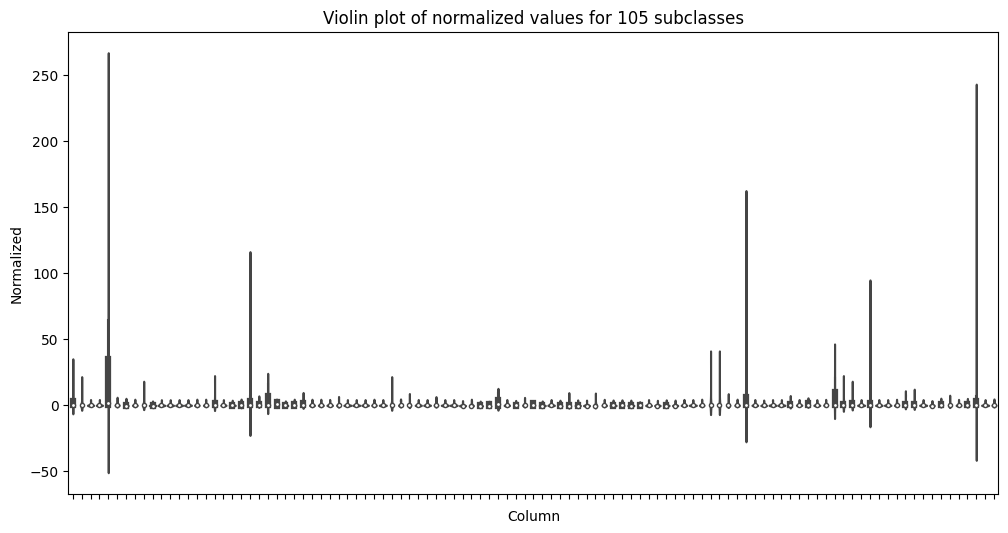

In [40]:
tdf_plot = tdf.drop(columns=zero_mean_columns)
df_std = (tdf_plot - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels([])
plt.title("Violin plot of normalized values for 105 subclasses")
print(len(train_df.shape))
# _ = ax.set_xticklabels(tdf.keys(), rotation=90)

#### Generating and defining stuff

In [41]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [42]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
      [labels[:, :, self.column_indices[name]] for name in self.label_columns],
      axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Create tf.data.Datasets

In [43]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=16,
    )

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [44]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

def compile_and_fit

In [45]:
# Adjust Epochs and patience here as you see fit
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='mean_absolute_error',
    patience=patience,
    mode='min')

  model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
    run_eagerly=True)

  history = model.fit(
    window.train, epochs=MAX_EPOCHS,
    validation_data=window.val,
    callbacks=[early_stopping])
  
  return history

#### Multi-output models

In [46]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=5, label_width=5, shift=1)

for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (12, 1, 105)
Labels shape (batch, time, features): (12, 1, 105)


##### Models

Baseline

In [47]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [48]:
baseline = Baseline()

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 1s 628ms/step - loss: 171.9555 - mean_absolute_error: 2.4196


Dense

1/1 [==============================] - 0s 145ms/step - loss: 153.6616 - mean_absolute_error: 4.2241


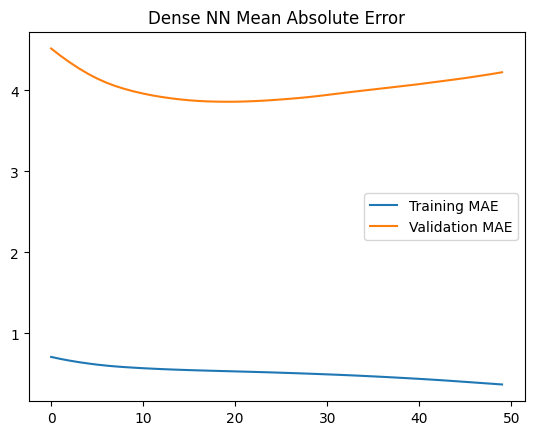

In [49]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title("Dense NN Mean Absolute Error")
plt.legend()

RNN/LSTM

1/1 [==============================] - 0s 152ms/step - loss: 135.6449 - mean_absolute_error: 2.2263


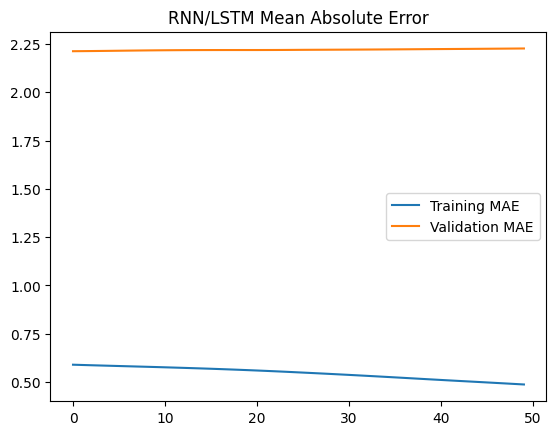

In [50]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history1 = compile_and_fit(lstm_model, single_step_window)

clear_output()
val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)

plt.plot(history1.history['mean_absolute_error'], label='Training MAE')
plt.plot(history1.history['val_mean_absolute_error'], label='Validation MAE')
plt.title("RNN/LSTM Mean Absolute Error")
plt.legend()

Residual LSTM

In [51]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

1/1 [==============================] - 0s 149ms/step - loss: 171.9794 - mean_absolute_error: 2.4860


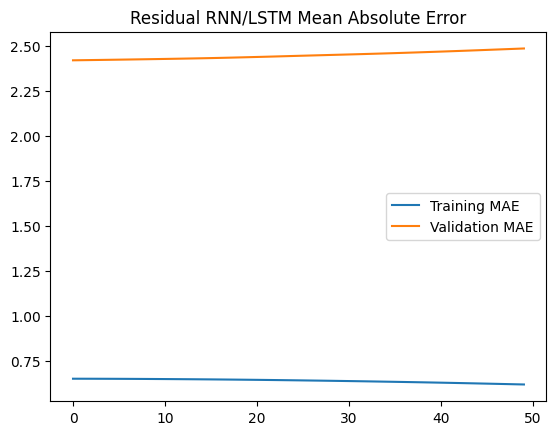

In [52]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history2 = compile_and_fit(residual_lstm, single_step_window)

clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(single_step_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(single_step_window.test, verbose=0)

plt.plot(history2.history['mean_absolute_error'], label='Training MAE')
plt.plot(history2.history['val_mean_absolute_error'], label='Validation MAE')
plt.title("Residual RNN/LSTM Mean Absolute Error")
plt.legend()

Performance of multi-output models

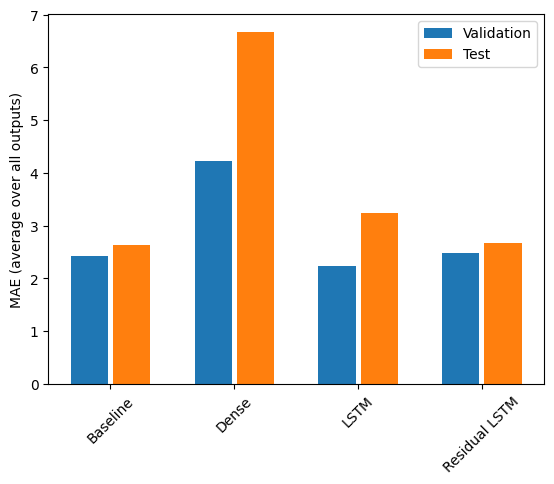

In [53]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [54]:
print(val_performance)
print(performance)

{'Baseline': [171.95550537109375, 2.419590473175049], 'Dense': [153.66163635253906, 4.224057197570801], 'LSTM': [135.64488220214844, 2.226297616958618], 'Residual LSTM': [171.9793701171875, 2.4860031604766846]}
{'Baseline': [73.7892074584961, 2.6214823722839355], 'Dense': [156.12200927734375, 6.677814483642578], 'LSTM': [118.01715850830078, 3.2294118404388428], 'Residual LSTM': [73.72473907470703, 2.6768009662628174]}


#### Multi-step models

In [55]:
def plot(self, model=None, plot_col='F02D', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Year')

WindowGenerator.plot = plot

Last Baseline

Total window size: 10
Input indices: [0 1 2 3 4]
Label indices: [5 6 7 8 9]
Label column name(s): None

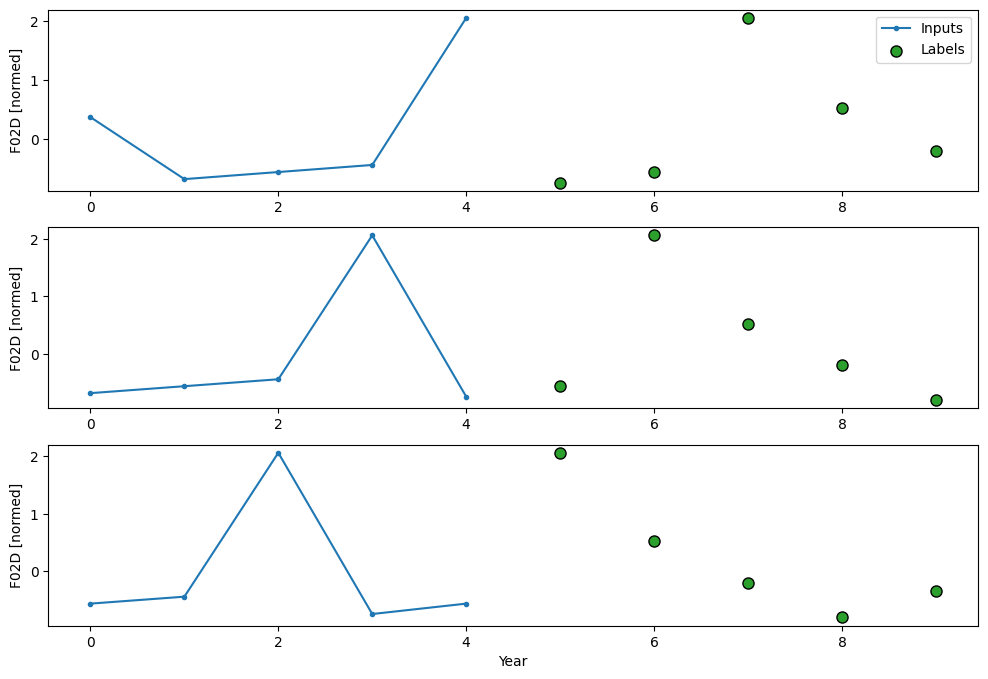

In [56]:
OUT_STEPS = 5
multi_window = WindowGenerator(input_width=5,
                               label_width=5,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [57]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
# multi_window.plot(last_baseline)

1/1 [==============================] - 0s 356ms/step - loss: 124.3382 - mean_absolute_error: 2.2061


In [58]:
print(multi_val_performance)
print(multi_performance)

{'Last': [124.33815002441406, 2.2061357498168945]}
{'Last': [45.412384033203125, 2.2877135276794434]}


Repeat Baseline

1/1 [==============================] - 0s 323ms/step - loss: 211.5288 - mean_absolute_error: 2.6452


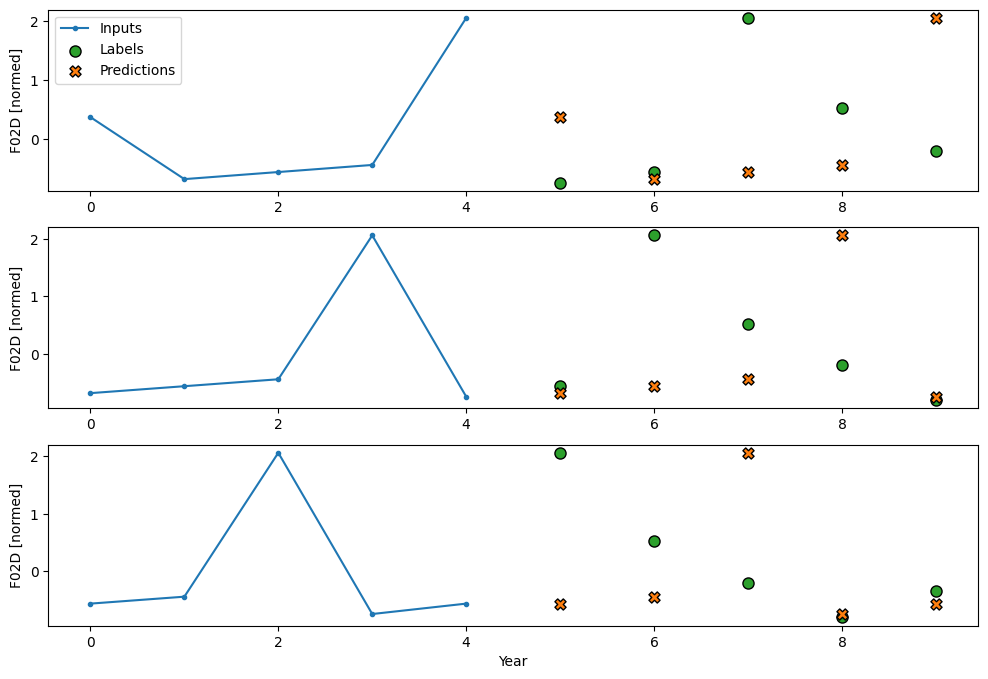

In [59]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

Multi-linear

1/1 [==============================] - 0s 146ms/step - loss: 158.6737 - mean_absolute_error: 3.4568


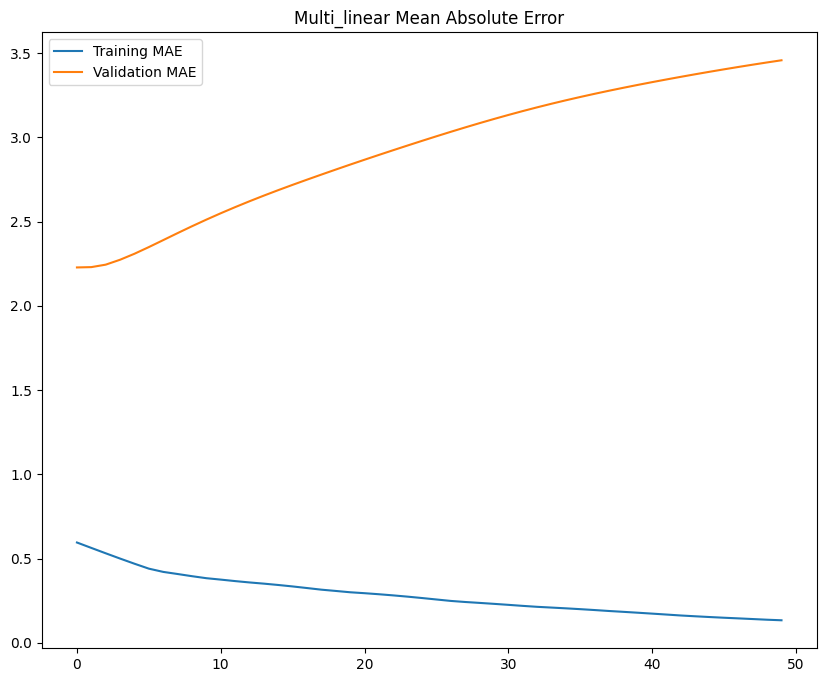

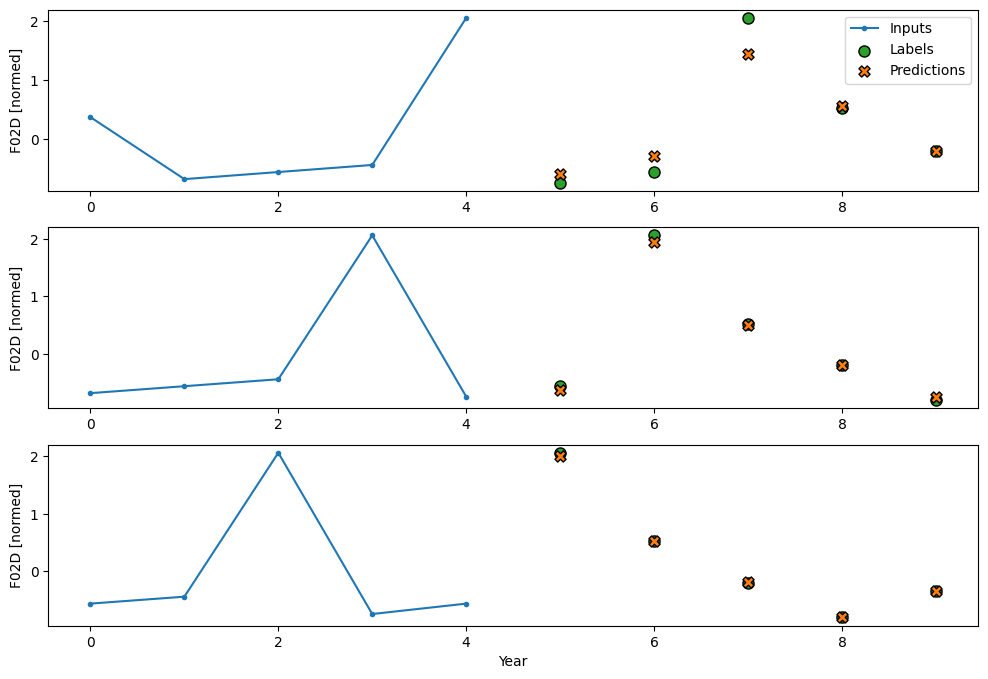

In [60]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history3 = compile_and_fit(multi_linear_model, multi_window)

clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

# Create a figure with two subplots: one for the history plots and one for the multi_window plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot training and validation MAE history on the first subplot (ax1)
ax.plot(history3.history['mean_absolute_error'], label='Training MAE')
ax.plot(history3.history['val_mean_absolute_error'], label='Validation MAE')
ax.set_title("Multi_linear Mean Absolute Error")
ax.legend()
plt.show()

multi_window.plot(multi_linear_model)


CNN

1/1 [==============================] - 0s 143ms/step - loss: 148.4365 - mean_absolute_error: 2.6182


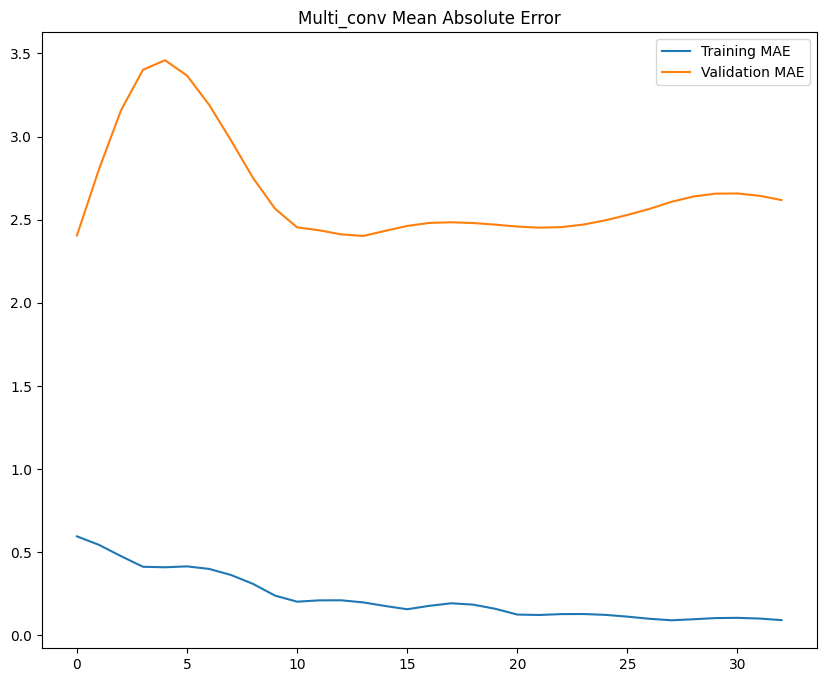

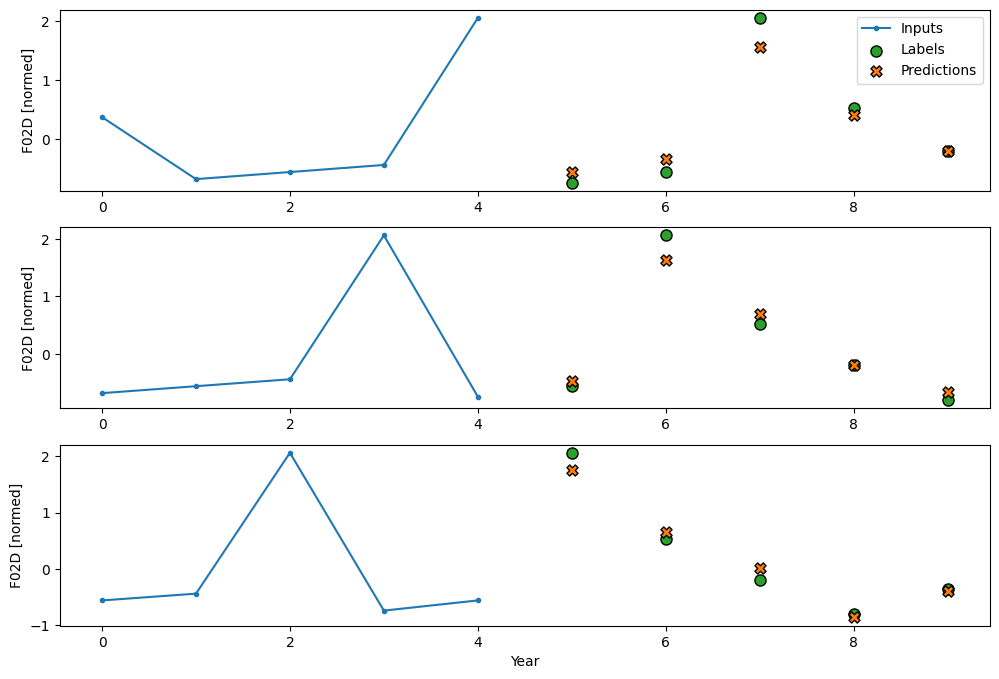

In [61]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history4 = compile_and_fit(multi_conv_model, multi_window)

clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

# Create a figure with two subplots: one for the history plots and one for the multi_window plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot training and validation MAE history on the first subplot (ax1)
ax.plot(history4.history['mean_absolute_error'], label='Training MAE')
ax.plot(history4.history['val_mean_absolute_error'], label='Validation MAE')
ax.set_title("Multi_conv Mean Absolute Error")
ax.legend()
plt.show()

multi_window.plot(multi_conv_model)

Mutli_LSTM

1/1 [==============================] - 0s 166ms/step - loss: 146.8356 - mean_absolute_error: 2.2345


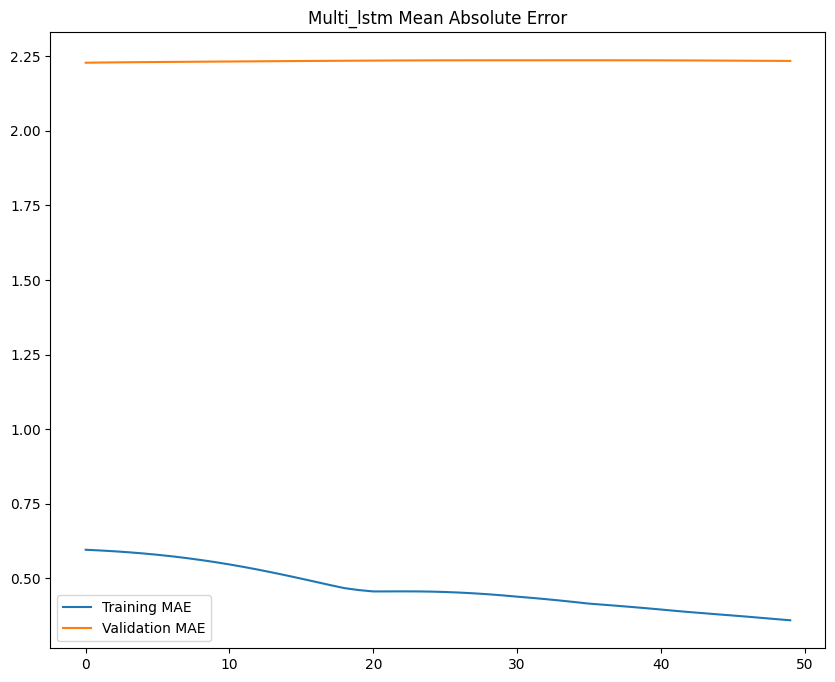

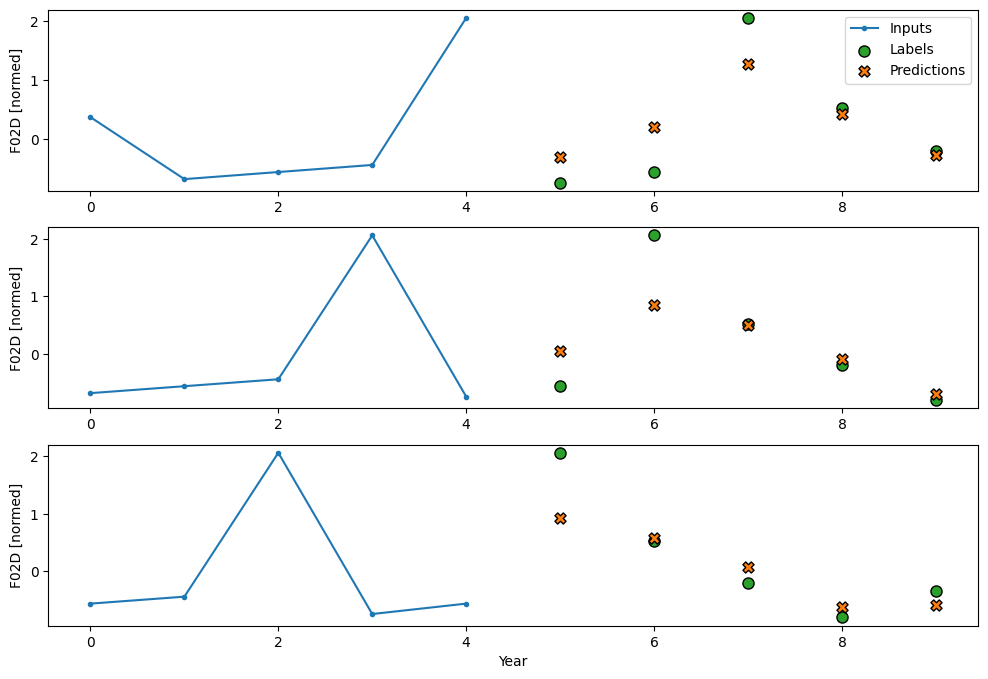

In [62]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history5 = compile_and_fit(multi_lstm_model, multi_window)

clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

# Create a figure with two subplots: one for the history plots and one for the multi_window plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot training and validation MAE history on the first subplot (ax1)
ax.plot(history5.history['mean_absolute_error'], label='Training MAE')
ax.plot(history5.history['val_mean_absolute_error'], label='Validation MAE')
ax.set_title("Multi_lstm Mean Absolute Error")
ax.legend()
plt.show()

multi_window.plot(multi_lstm_model)

Multi_Dense

1/1 [==============================] - 0s 153ms/step - loss: 148.0417 - mean_absolute_error: 2.7213


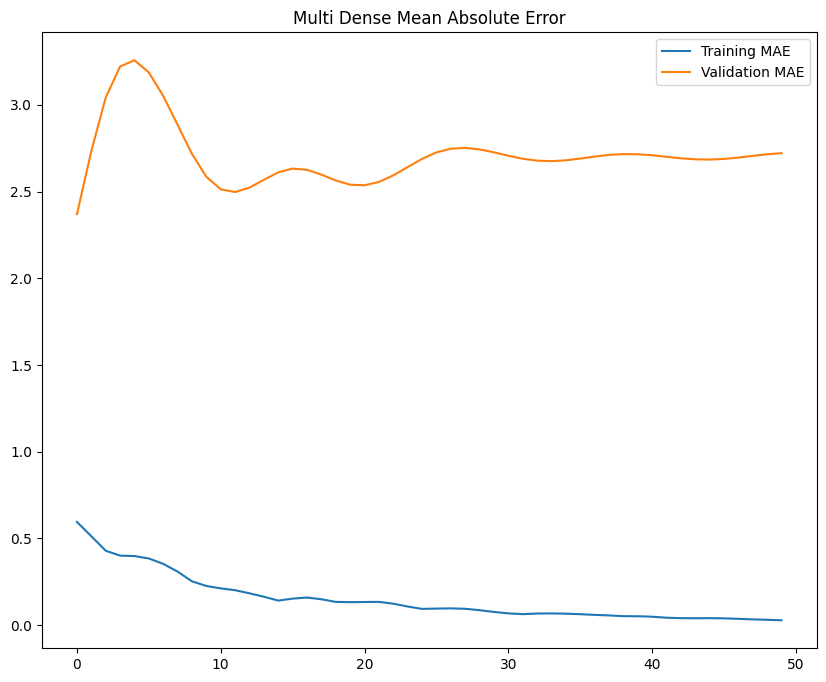

In [63]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history99 = compile_and_fit(multi_dense_model, multi_window)

clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
# multi_window.plot(multi_dense_model)
# Create a figure with two subplots: one for the history plots and one for the multi_window plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot training and validation MAE history on the first subplot (ax1)
ax.plot(history99.history['mean_absolute_error'], label='Training MAE')
ax.plot(history99.history['val_mean_absolute_error'], label='Validation MAE')
ax.set_title("Multi Dense Mean Absolute Error")
ax.legend()
plt.show()

Autoregressive RNN

In [64]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([4, 105])

In [65]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [66]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (4, 5, 105)


1/1 [==============================] - 0s 186ms/step - loss: 146.6698 - mean_absolute_error: 2.2473


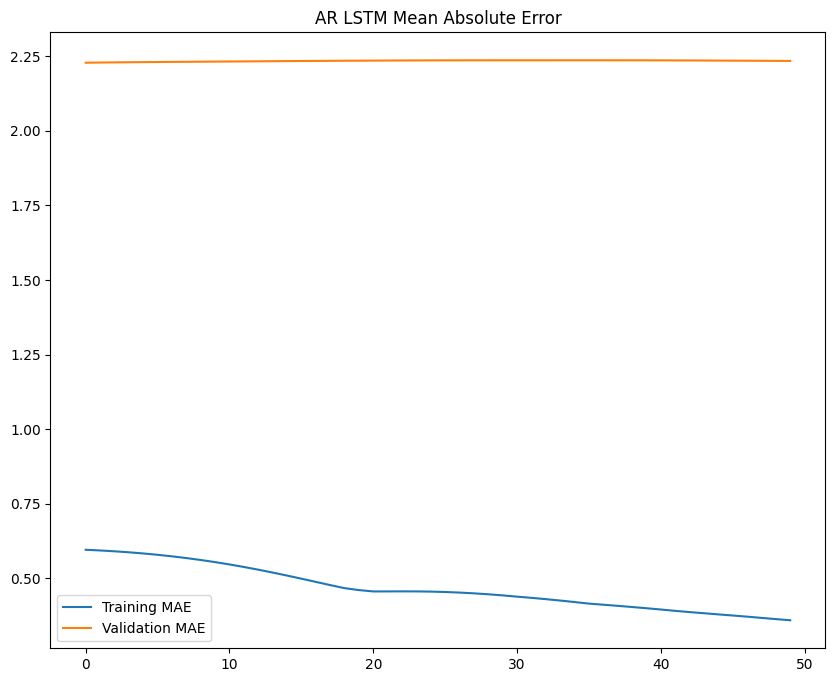

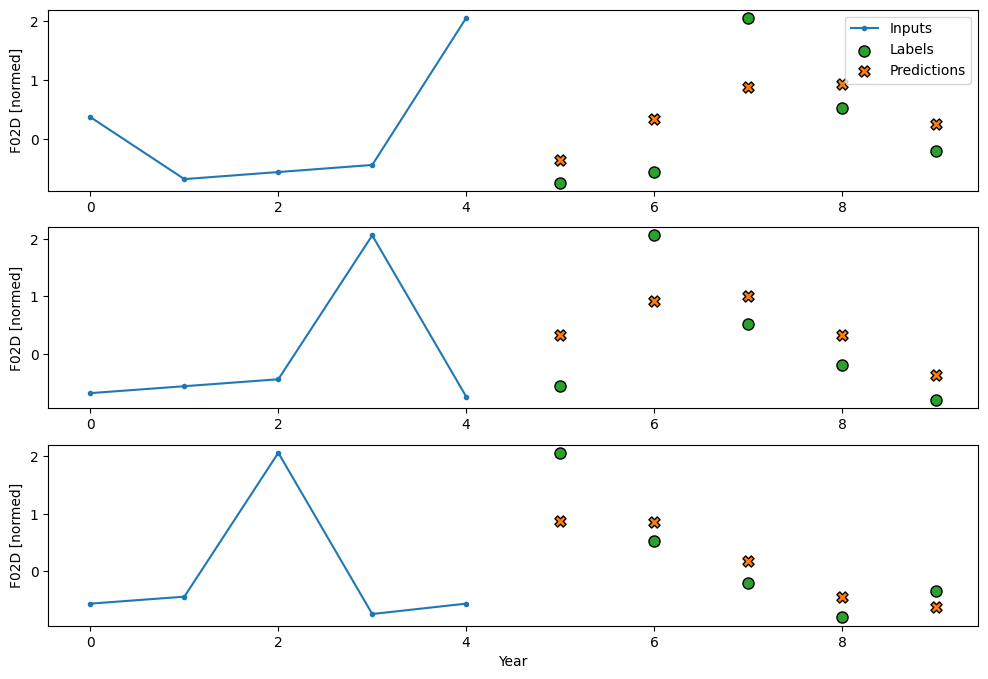

In [67]:
history6 = compile_and_fit(feedback_model, multi_window)

clear_output()
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

# Create a figure with two subplots: one for the history plots and one for the multi_window plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot training and validation MAE history on the first subplot (ax1)
ax.plot(history5.history['mean_absolute_error'], label='Training MAE')
ax.plot(history5.history['val_mean_absolute_error'], label='Validation MAE')
ax.set_title("AR LSTM Mean Absolute Error")
ax.legend()
plt.show()

multi_window.plot(feedback_model)

Performance of Multi-Step Multi-Output models

In [68]:
print(multi_val_performance)
print(multi_performance)

{'Last': [124.33815002441406, 2.2061357498168945], 'Repeat': [211.52877807617188, 2.645238161087036], 'Linear': [158.6737060546875, 3.456815242767334], 'Conv': [148.43650817871094, 2.6181817054748535], 'LSTM': [146.83560180664062, 2.2345492839813232], 'Dense': [148.0416717529297, 2.721348762512207], 'AR LSTM': [146.66981506347656, 2.247298002243042]}
{'Last': [45.412384033203125, 2.2877135276794434], 'Repeat': [78.26112365722656, 2.9469566345214844], 'Linear': [176.43798828125, 6.460502624511719], 'Conv': [143.02223205566406, 4.13932466506958], 'LSTM': [140.3769073486328, 3.7479255199432373], 'Dense': [143.47340393066406, 4.313565254211426], 'AR LSTM': [139.6764678955078, 3.7468833923339844]}


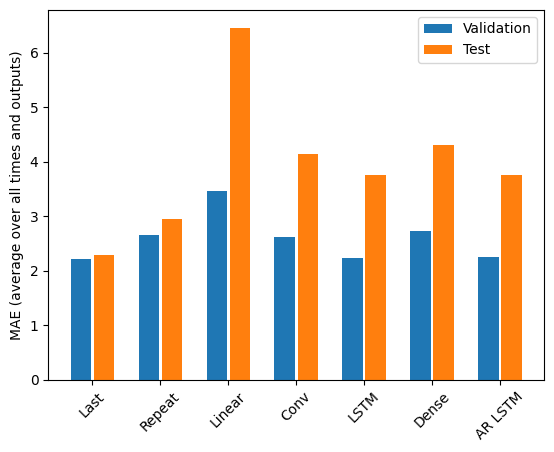

In [69]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

### Audio-related attempts

In [70]:
def elementwise_sum(list1, list2):
    result = [x + y for x, y in zip(list1, list2)]
    return result

def elementwise_subtract(list1, list2):
    result = [x - y for x, y in zip(list1, list2)]
    return result

Plots cumulative sum graph for a single column

In [71]:
def plot_cumulative_sum(df, n=None, col=None):
    '''
    Takes in a dataframe with the object columns from the 2nd one onwards and outputs a cumulative sine graph

    Inputs: 
    df  :   DataFrame WITH "Years" column
    n   :   Cumulative sum forgets n number of steps (years) before. n = 1 if not specified.
    col :   (Optional) Plots a specific column if specified. Otherwise plots a random column.

    Outputs:
    On same fig:
    Graph 1: Original Frequencies plot
    Graph 2: Cumulative sine graphs in time with window n
    Graph 3: Maximum cumulative sum vs normalized data between each time interval.
    '''
    if n is None:
        n = 1
    
    if col is None:
        col = np.random.choice(df.columns[1:])  # Randomly select a column
    years = pd.to_datetime(df['Years']).dt.year
    expanded_df = pd.DataFrame(columns=['t', col, 'cum_sum','5_year_forget'])
    
    for idx, freq in enumerate(df[col]):
        t = np.arange(idx, idx + 1, 0.01)
        y = np.sin(2 * np.pi * freq * t)
        expanded_df = expanded_df.append({'t': t, col: y, 'cum_sum': np.zeros(len(t)),'5_year_cum_sum': np.zeros(len(t))}, ignore_index=True)
    flattened_t = np.concatenate(expanded_df['t'].values)
    
    for i in range(len(expanded_df)):
        if i == 0:
            expanded_df.at[i,'cum_sum'] = expanded_df.at[i, col]
        else: 
            expanded_df.at[i, 'cum_sum'] = elementwise_sum(expanded_df.at[i, col], expanded_df.at[i-1, 'cum_sum'])
    
    for i in range(len(expanded_df)):
        if i <= n:
            expanded_df.at[i,'5_year_cum_sum'] = expanded_df.at[i,'cum_sum']
        else:
            expanded_df.at[i,'5_year_cum_sum'] = elementwise_subtract(expanded_df.at[i, 'cum_sum'], expanded_df.at[i-n, 'cum_sum'])
    flattened_cumulative_sum = np.concatenate(expanded_df['5_year_cum_sum'].values)
    
    original_vals = [x for x in df[col] for _ in range(100)]
    if all(val == 0 for val in original_vals):
        normalized_vals = [0] * len(original_vals)
    else:
        min_val = min(original_vals)
        max_val = max(original_vals)
        normalized_vals = [(x - min_val) / (max_val - min_val) for x in original_vals]
        normalized_vals = [x for x in normalized_vals]

    # Create a list to store the maximum values
    max_values = []

    # Iterate through the values in steps of 100
    for i in range(0, len(flattened_cumulative_sum), 100):
        max_val = np.max(flattened_cumulative_sum[i:i+100])
        max_values.append(max_val)

    col_to_plot = df[col]

    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, nrows = 1, figsize=(16,5))
    # ax4.set_visible(False)
    ax1.plot(years, col_to_plot)
    ax1.set_xlabel("Years")
    ax1.set_ylabel("Values")
    ax1.set_title(f'Original patent frequencies for {col}')
    # xtick_years = range(1980, 2016, 5)
    # xtick_pos = [0,5,10,15,20,25,30,35]
    # ax1.set_xticks(xtick_years, xtick_pos)
    #  ax1.set_xticklabels(xtick_years, rotation=70)

    ax2.plot(flattened_t, flattened_cumulative_sum, label='Cumulative Sum')
    ax2.plot(flattened_t, normalized_vals, label=col)  # Plot original column values
    ax2.set_xlabel('Years')
    ax2.set_ylabel('Values')
    ax2.set_ylim([-max(max_values)-1,max(max_values)+1])
    ax2.set_title(f'Cumulative sine waves and frequency for {col}')
    # plt.legend()
    
    # Add vertical dotted lines at every 5th year
    selected_years = years[::5]
    vertical_lines = flattened_t[::(len(flattened_t) // len(selected_years))]
    for line in vertical_lines:
        ax2.axvline(x=line, color='grey', linestyle='--', alpha=0.5)

    ax3.scatter(normalized_vals[::100], max_values)
    ax3.set_xlabel('Normalized Values')
    ax3.set_ylabel('Maximum Cumulative Sum')
    ax3.set_title('Maximum Cumulative Sum vs. Normalized Values')
    ax3.grid(True)

    plt.show()

Functions to: 
1. Return cumulative sum for a single column - cum_sum_col(col, n)
1. Return cumulative sum for a dataframe - cum_sum_df(df, n)

In [72]:
def cum_sum_col(col, n):
    '''
    Takes in a dataframe column outputs a dataframe of n_year_cum_sum

    Inputs: 
    col     :   Column of a dataframe with numerical values
    n       :   Cumulative sum forgets more than n number of steps (years) before, so (n+1) and more years ago.

    Outputs:
    expanded_df: dataframe for a single column input, with a single column of its n_year_cum_sum
    '''
    expanded_df = pd.DataFrame(columns=['t', 'y','cum_sum', f'{n}_year_{col}'])
    
    for idx, freq in enumerate(col):
        t = np.arange(idx, idx + 1, 0.01)
        y = np.sin(2 * np.pi * freq * t)
        expanded_df = expanded_df.append({'t': t, 'y': y, 'cum_sum' : np.zeros(len(t)), f'{n}_year_{col}': np.zeros(len(t))}, ignore_index=True)
    # flattened_t = np.concatenate(expanded_df['t'].values)
    
    for i in range(len(expanded_df)):
        if i == 0:
            expanded_df.at[i,'cum_sum'] = expanded_df.at[i, 'y']
        else: 
            expanded_df.at[i, 'cum_sum'] = elementwise_sum(expanded_df.at[i, 'y'], expanded_df.at[i-1, 'cum_sum'])
    # The below is TESTING. Drop the if else if it doesn't work.
    if n >= 1:
        for i in range(len(expanded_df)):
            if i <= n:
                expanded_df.at[i,f'{n}_year_{col}'] = expanded_df.at[i,'cum_sum']
            else:
                expanded_df.at[i,f'{n}_year_{col}'] = elementwise_subtract(expanded_df.at[i, 'cum_sum'], expanded_df.at[i-n, 'cum_sum'])
    # flattened_cumulative_sum = np.concatenate(expanded_df['5_year_cum_sum'].values)
    else:
        pass
    expanded_df = expanded_df.drop(['t','y','cum_sum'], axis=1)
    return expanded_df

def cum_sum_df(df, n):
    '''   
    Returns cumulative sum dataframe that forgets more than n steps before.

    Inputs: 
    df  : Dataframe
    n   : integer value

    Outputs:
    new_df  : cumulative sum dataframe
    '''
    new_df = pd.DataFrame()
    for col in df.columns[1:]:
        col_df = cum_sum_col(df[col], n)
        new_df[col] = col_df
    return new_df

Example use cases with n = 5

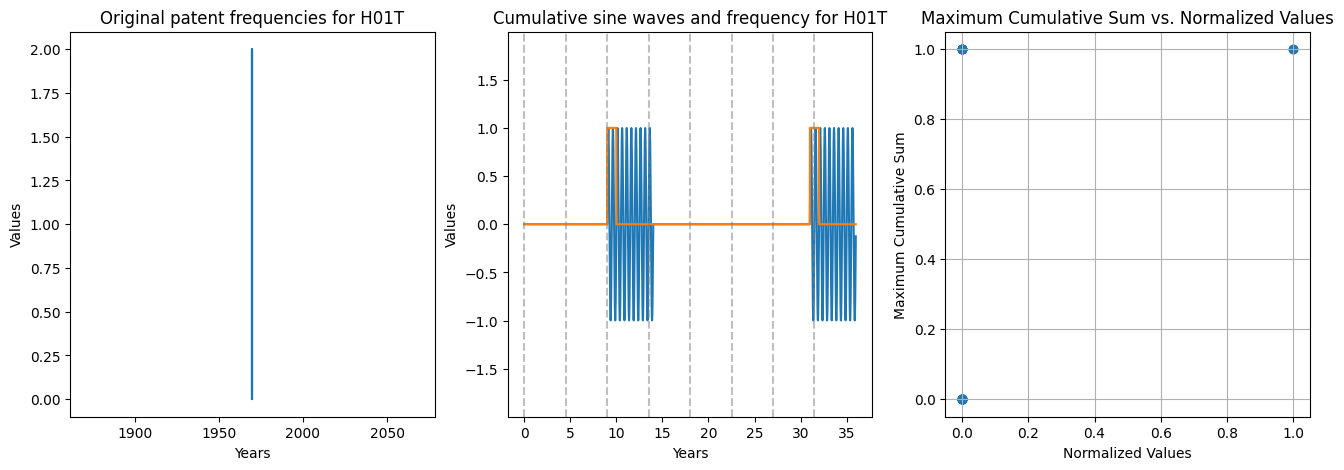

[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]


In [73]:
rand_col = np.random.choice(total_df.columns[1:])
plot_cumulative_sum(total_df, 5, rand_col)
print(total_df[rand_col].tolist())

In [74]:
total_cum_sum = cum_sum_df(total_df, 5)
total_cum_sum.head(2)

,A01B,A01C,A01D,A01F,A01G,A01H,A01J,A01K,A01L,A01M,...,H04R,H04S,H04W,H05B,H05C,H05F,H05G,H05H,H05K,H99Z
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.12533323356430426, 0.2486898871648548,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.12533323356430426, 0.2486898871648548,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Prev. Depreciated Attempts
1. Includes attempts at LSTM with and without market data.

In [75]:
# You can download the current data (2023) from Yahoo Finance here:
# https://finance.yahoo.com/quote/VOW3.DE/history?p=VOW3.DE
# The data below starts from August 1998 when Volkswagen was listed on the stock market
volks_monthly = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\VOW3.DE_monthly.csv"
share_monthly = pd.read_csv(volks_monthly)
volks_daily = r"C:\Users\james\OneDrive\Desktop\Thesis\Data\VOW3.DE_daily.csv"
share_daily = pd.read_csv(volks_daily)
# volks_share_df.head(2)

In [76]:
from datetime import datetime, timedelta
# Convert 'Years' column to datetime type
volks_4_df['Years'] = pd.to_datetime(volks_4_df['Years'])
share_monthly['Date']= pd.to_datetime(share_monthly['Date'])

monthly_dates = pd.date_range(start="1980-01-01", end="2010-12-01", freq="MS")

# Create a new DataFrame for extended data
extended_data = []

for _, row in volks_4_df.iterrows():
    year = row['Years'].year
    for month_date in monthly_dates:
        if month_date.year == year:
            new_row = row.copy()
            new_row['Years'] = month_date
            for column in volks_4_df.columns[1:]:
                new_row[column] = row[column] / 12
            extended_data.append(new_row)

extended_df = pd.DataFrame(extended_data).reset_index(drop=True)

# Merge the two dataframes using an outer join and filling missing values with 0
merged_df = share_monthly.merge(extended_df, left_on='Date', right_on='Years', how='outer').fillna(0)

# Drop the redundant 'Years' column
merged_df = merged_df.drop('Years', axis=1)

merged_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,A01B,A01C,A01D,...,H04R,H04S,H04W,H05B,H05C,H05F,H05G,H05H,H05K,H99Z
0,1998-08-01 00:00:00,55.397781,58.395748,42.564972,42.945683,15.798517,2002462.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1998-09-01 00:00:00,42.437737,48.790524,33.645622,38.117722,14.022446,2757980.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1998-10-01 00:00:00,36.999447,40.887066,30.240105,37.965637,13.966495,3829184.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1998-11-01 00:00:00,40.633587,46.757751,40.150494,44.521206,16.378105,2045085.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1998-12-01 00:00:00,43.453625,44.521206,37.889095,40.963604,15.069366,2162233.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### LSTM with/without market data
1. Using three years to predict one future year. 
1. So far results do not look promising for with-market data. This could be attributed to <br> the issue of taking 'means' of a year's frequencies to 12 months to merge with market data.
1. Should retry with B60/B60L level 4 data.
1. Should increase epochs for next training session and adjust hyperparameters.

In [77]:
from datetime import datetime, timedelta
# Convert 'Years' column to datetime type
volks_4_df['Years'] = pd.to_datetime(volks_4_df['Years'])
share_monthly['Date']= pd.to_datetime(share_monthly['Date'])

monthly_dates = pd.date_range(start="1980-01-01", end="2010-12-01", freq="MS")

# Create a new DataFrame for extended data
extended_data = []

for _, row in volks_4_df.iterrows():
    year = row['Years'].year
    for month_date in monthly_dates:
        if month_date.year == year:
            new_row = row.copy()
            new_row['Years'] = month_date
            for column in volks_4_df.columns[1:]:
                new_row[column] = row[column] / 12
            extended_data.append(new_row)

extended_df = pd.DataFrame(extended_data).reset_index(drop=True)

# Merge the two dataframes using an outer join and filling missing values with 0
merged_df = share_monthly.merge(extended_df, left_on='Date', right_on='Years', how='outer').fillna(0)

# Drop the redundant 'Years' column
merged_df = merged_df.drop('Years', axis=1)

merged_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,A01B,A01C,A01D,...,H04R,H04S,H04W,H05B,H05C,H05F,H05G,H05H,H05K,H99Z
0,1998-08-01 00:00:00,55.397781,58.395748,42.564972,42.945683,15.798517,2002462.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1998-09-01 00:00:00,42.437737,48.790524,33.645622,38.117722,14.022446,2757980.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1998-10-01 00:00:00,36.999447,40.887066,30.240105,37.965637,13.966495,3829184.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1998-11-01 00:00:00,40.633587,46.757751,40.150494,44.521206,16.378105,2045085.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1998-12-01 00:00:00,43.453625,44.521206,37.889095,40.963604,15.069366,2162233.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Callbacks

In [78]:
# Used to save best model up to last complete epoch
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath='weights_best_Deset_model.hdf5',
    monitor='val_mae', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
    # mode = 'auto'
)

# Reduce learning rate above patience threshold if accuracy stagnates
reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    patience=10,
    verbose=1,
    factor=0.5,
    min_lr=1e-6
)

# Stores epoch results in a csv file
# csv_logger = keras.callbacks.CSVLogger('120.csv', append=True)
callbacks = [checkpointer, reduce]

##### LSTM WITH MARKET MODEL

In [79]:
cols_to_rm = merged_df.columns[7:]
for col in cols_to_rm:
    if merged_df[col].sum() <= 5:
        merged_df.drop(columns=col, inplace=True)

cols = list(merged_df)[1:]
from sklearn.preprocessing import StandardScaler
test_df = merged_df[cols].astype(float)
scaler = StandardScaler()
scaler = scaler.fit(test_df)
test_df_scaled = scaler.transform(test_df)

In [80]:
trainX = []
trainY = []

n_future = 12
n_past = 36

for i in range(n_past, len(test_df_scaled) - n_future +1):
    trainX.append(test_df_scaled[i - n_past:i, 0:test_df.shape[1]])
    trainY.append(test_df_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (325, 36, 151).
trainY shape == (325, 1).


In [81]:
init_LR = 1e-3

model = Sequential()
model.add(LSTM(256, activation='relu',  input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(128, activation = 'relu',return_sequences=True))
model.add(LSTM(64,  activation = 'relu',return_sequences=True))
model.add(LSTM(32,  activation='relu',  return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(
    optimizer=tf.keras.optimizers.Adam(init_LR), 
    loss='mae', 
    metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError()]
    )

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 36, 256)           417792    
                                                                 
 lstm_4 (LSTM)               (None, 36, 128)           197120    
                                                                 
 lstm_5 (LSTM)               (None, 36, 64)            49408     
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 676,769
Trainable params: 676,769
Non-tr

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.8358 - mae: 0.8358 - mse: 1.0310 - root_mean_squared_error: 1.0154
Epoch 1: val_mae improved from inf to 0.42222, saving model to weights_best_Deset_model.hdf5
19/19 [==============================] - 13s 226ms/step - loss: 0.8358 - mae: 0.8358 - mse: 1.0310 - root_mean_squared_error: 1.0154 - val_loss: 0.4222 - val_mae: 0.4222 - val_mse: 0.2021 - val_root_mean_squared_error: 0.4495 - lr: 0.0010
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 2.2159 - mae: 2.2159 - mse: 30.3647 - root_mean_squared_error: 5.5104
Epoch 2: val_mae did not improve from 0.42222
19/19 [==============================] - 3s 151ms/step - loss: 2.2159 - mae: 2.2159 - mse: 30.3647 - root_mean_squared_error: 5.5104 - val_loss: 0.6501 - val_mae: 0.6501 - val_mse: 0.4230 - val_root_mean_squared_error: 0.6504 - lr: 0.0010
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 2.7566 - mae: 2.7566 - mse: 101.9008 - r

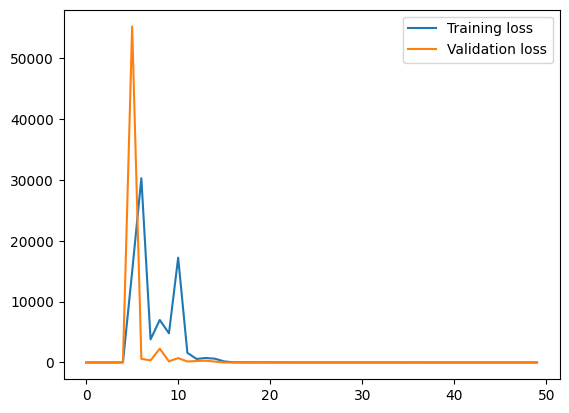

In [82]:
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, callbacks=callbacks, shuffle=False)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

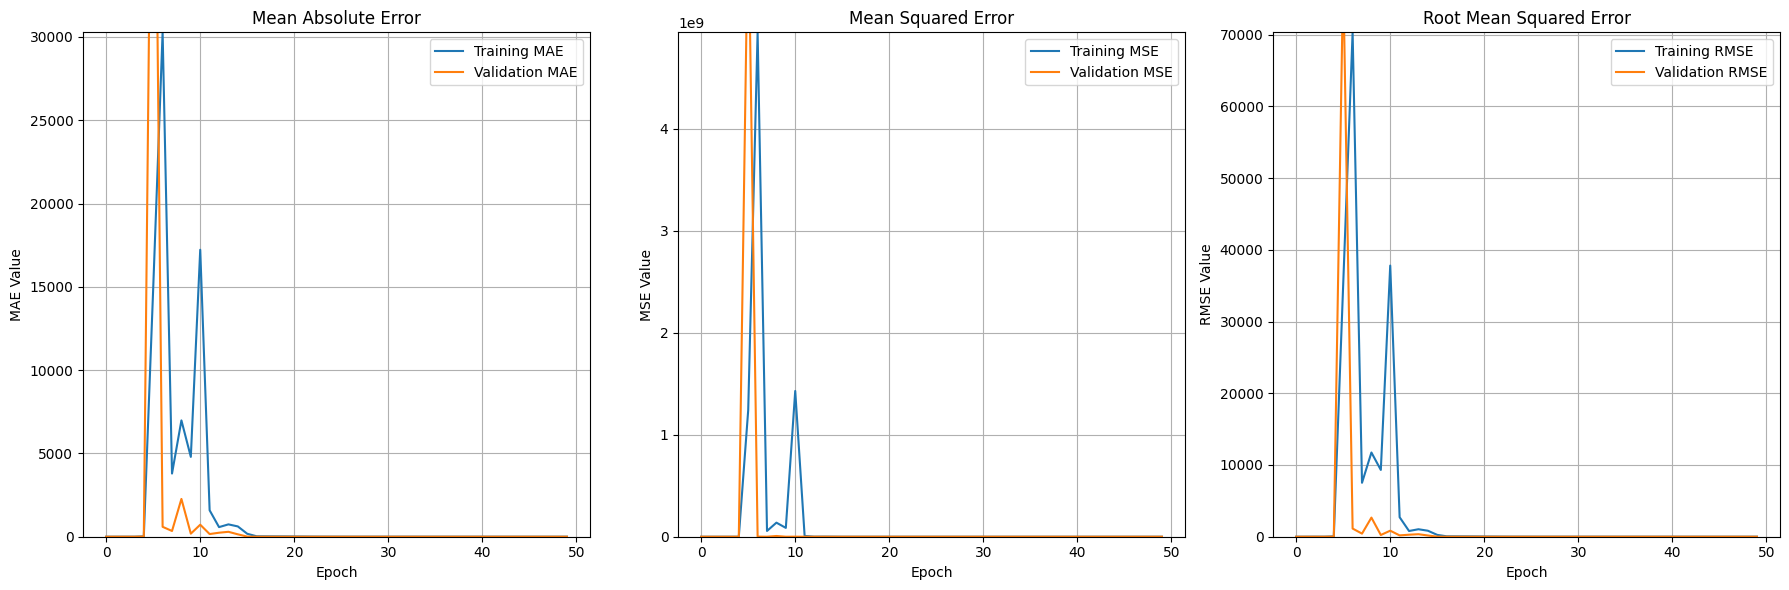

In [83]:
# Create a figure with three subplots in a row
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Calculate upper limits for y-axes based on desired spacing
spacing = 0.2  # Adjust this to your desired spacing

upper_limit_mae = spacing * ((max(history.history['mae']) // spacing) + 3)
upper_limit_mse = spacing * ((max(history.history['mse']) // spacing) + 1)
upper_limit_rmse = spacing * ((max(history.history['root_mean_squared_error']) // spacing) + 1)

# Plot MAE
axs[0].plot(history.history['mae'], label='Training MAE')
axs[0].plot(history.history['val_mae'], label='Validation MAE')
axs[0].set_title('Mean Absolute Error')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MAE Value')
axs[0].legend()
axs[0].grid(True)
axs[0].set_ylim([0, upper_limit_mae])

# Plot MSE
axs[1].plot(history.history['mse'], label='Training MSE')
axs[1].plot(history.history['val_mse'], label='Validation MSE')
axs[1].set_title('Mean Squared Error')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MSE Value')
axs[1].legend()
axs[1].grid(True)
axs[1].set_ylim([0, upper_limit_mse])

# Plot RMSE
axs[2].plot(history.history['root_mean_squared_error'], label='Training RMSE')
axs[2].plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
axs[2].set_title('Root Mean Squared Error')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('RMSE Value')
axs[2].legend()
axs[2].grid(True)
axs[2].set_ylim([0, upper_limit_rmse])

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

##### LSTM WITHOUT MARKET MODEL


In [84]:
#Drop the date col
v4 = volks_4_df.copy()
v4 = v4.drop(v4.columns[0], axis=1)

# Find number of columns whose sum is more than 5
five_less_cols = []
for column in v4.columns:
    column_sum = v4[column].sum()
    if column_sum <= 5:
        five_less_cols.append(column)

v4.drop(columns=five_less_cols, inplace=True)

In [85]:
from sklearn.preprocessing import StandardScaler
v4_test_df = v4.astype(int)
scaler = StandardScaler()
scaler = scaler.fit(v4_test_df)
v4_test_df_scaled = scaler.transform(v4_test_df)

In [86]:
trainX = []
trainY = []

n_future = 1
n_past = 5

for i in range(n_past, len(v4_test_df_scaled) - n_future +1):
    trainX.append(v4_test_df_scaled[i - n_past:i, 0:test_df.shape[1]])
    trainY.append(v4_test_df_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

# print('trainX shape == {}.'.format(trainX.shape))
# print('trainY shape == {}.'.format(trainY.shape))

init_LR = 1e-3

model = Sequential()
model.add(LSTM(256, activation='relu',  input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(128, activation = 'relu',return_sequences=True))
model.add(LSTM(64,  activation = 'relu',return_sequences=True))
model.add(LSTM(32,  activation='relu',  return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(
    optimizer=tf.keras.optimizers.Adam(init_LR), 
    loss='mae',
    metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 256)            411648    
                                                                 
 lstm_8 (LSTM)               (None, 5, 128)            197120    
                                                                 
 lstm_9 (LSTM)               (None, 5, 64)             49408     
                                                                 
 lstm_10 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 670,625
Trainable params: 670,625
Non-tr

Epoch 1/50
1/2 [==============>...............] - ETA: 9s - loss: 0.3618 - mae: 0.3618 - mse: 0.1403 - root_mean_squared_error: 0.3746
Epoch 1: val_mae did not improve from 0.13384
2/2 [==============================] - 11s 1s/step - loss: 0.6256 - mae: 0.6256 - mse: 1.3043 - root_mean_squared_error: 1.1420 - val_loss: 0.2965 - val_mae: 0.2965 - val_mse: 0.0923 - val_root_mean_squared_error: 0.3038 - lr: 0.0010
Epoch 2/50
1/2 [==============>...............] - ETA: 0s - loss: 0.3460 - mae: 0.3460 - mse: 0.1253 - root_mean_squared_error: 0.3540
Epoch 2: val_mae did not improve from 0.13384
2/2 [==============================] - 0s 97ms/step - loss: 0.6113 - mae: 0.6113 - mse: 1.2902 - root_mean_squared_error: 1.1359 - val_loss: 0.3067 - val_mae: 0.3067 - val_mse: 0.0952 - val_root_mean_squared_error: 0.3085 - lr: 0.0010
Epoch 3/50
1/2 [==============>...............] - ETA: 0s - loss: 0.3300 - mae: 0.3300 - mse: 0.1106 - root_mean_squared_error: 0.3325
Epoch 3: val_mae did not improve f

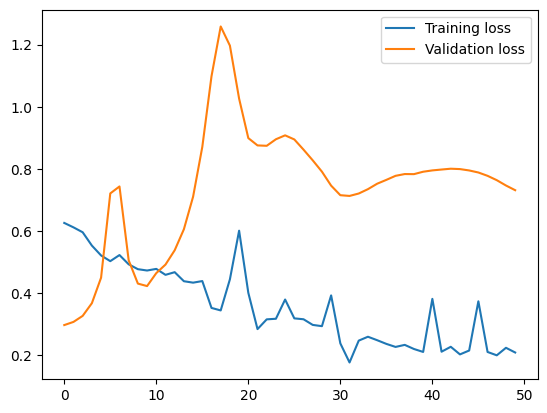

In [87]:
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, callbacks=callbacks, shuffle=False)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

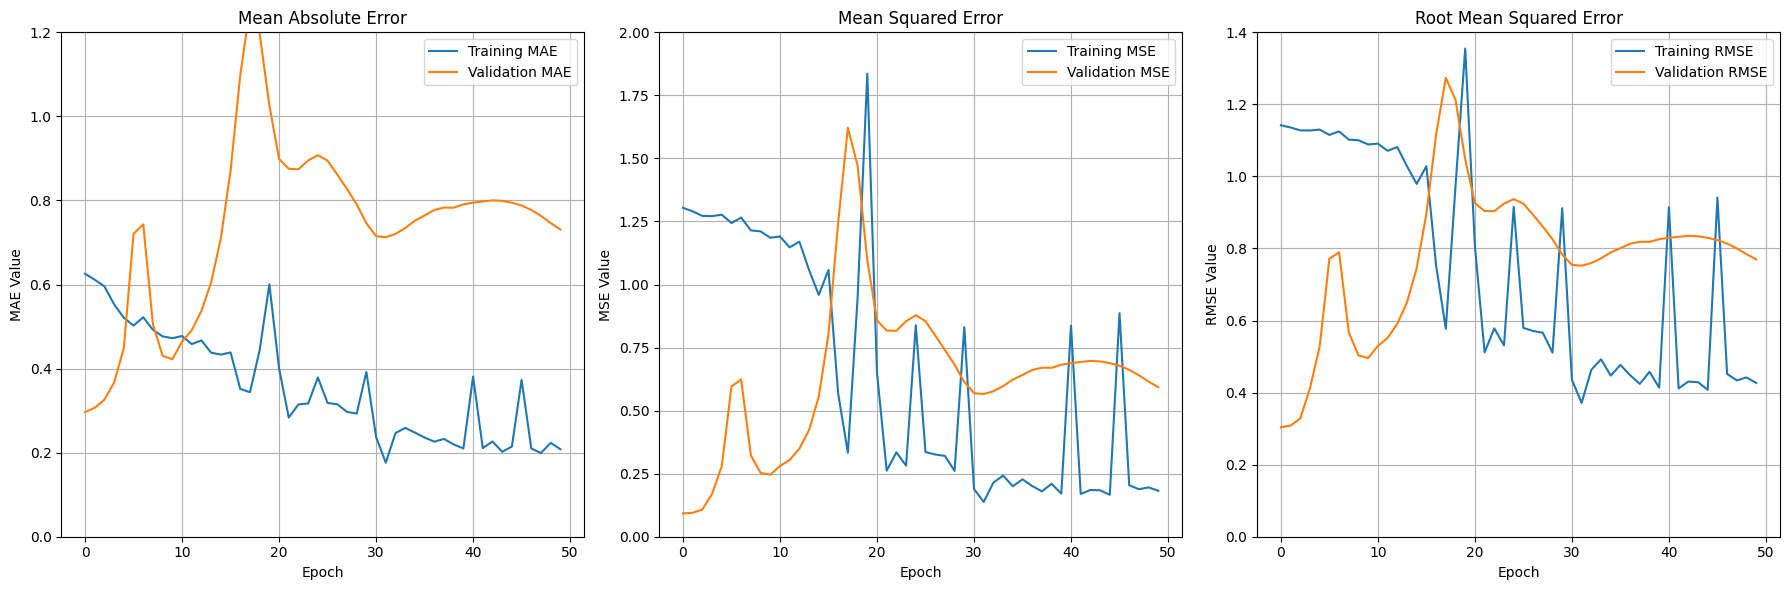

In [88]:
# Create a figure with three subplots in a row
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Calculate upper limits for y-axes based on desired spacing
spacing = 0.2  # Adjust this to your desired spacing

upper_limit_mae = spacing * ((max(history.history['mae']) // spacing) + 3)
upper_limit_mse = spacing * ((max(history.history['mse']) // spacing) + 1)
upper_limit_rmse = spacing * ((max(history.history['root_mean_squared_error']) // spacing) + 1)

# Plot MAE
axs[0].plot(history.history['mae'], label='Training MAE')
axs[0].plot(history.history['val_mae'], label='Validation MAE')
axs[0].set_title('Mean Absolute Error')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MAE Value')
axs[0].legend()
axs[0].grid(True)
axs[0].set_ylim([0, upper_limit_mae])

# Plot MSE
axs[1].plot(history.history['mse'], label='Training MSE')
axs[1].plot(history.history['val_mse'], label='Validation MSE')
axs[1].set_title('Mean Squared Error')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MSE Value')
axs[1].legend()
axs[1].grid(True)
axs[1].set_ylim([0, upper_limit_mse])

# Plot RMSE
axs[2].plot(history.history['root_mean_squared_error'], label='Training RMSE')
axs[2].plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
axs[2].set_title('Root Mean Squared Error')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('RMSE Value')
axs[2].legend()
axs[2].grid(True)
axs[2].set_ylim([0, upper_limit_rmse])

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Runtime for whole notebook

In [89]:
end_time = t.time()

In [90]:
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return hour, minutes, seconds

total_runtime_seconds = end_time - start_time
hour, minutes, seconds = convert(total_runtime_seconds)
print("Total runtime: {} hour(s), {} minutes, and {} seconds".format(hour, minutes, seconds))


Total runtime: 0.0 hour(s), 9.0 minutes, and 5.785089492797852 seconds
